In [1]:
import json

In [43]:


experiments_path = "../"

def fc_to_string(k,cfg):
    res = f"k_{k}bits_"
    for layer in cfg:
        res += str(layer["bits"]) + "."
    
    res +=  "logsize_"
    for layer in cfg:
        res = res + str(layer["logsize"]) + "."
    
    return res


def bits_str(cfg):
    res = "b."
    for layer in cfg:
        res += str(layer["bits"]) + "."
    
    return res

def logsize_str(cfg):
    res = "sz."
    for layer in cfg:
        res = res + str(layer["logsize"]) + "."
    
    return res
  
def load_configs(name):
    with open(f'{experiments_path}config_{name}', 'r') as myfile:
        data=myfile.read()
        obj = json.loads(data)
        return obj["config"]  

def load_exp(fn):
    try:
        with open(fn, 'r') as myfile:
            data=myfile.read()
            # print(data)
            obj = json.loads(data)
            return obj
    except Exception as err:
        print(err)
        return None

    
polygon_sets = [("Us Zip Codes", "tl_2017_us_zcta510"), ("Global LSB", "Global_LSIB_Polygons_Detailed")]
datasets =[("Twitter 1 mio","twitter_1mio_coords.h5"), 
           ("Twitter 10 mio","twitter_10mio_coords.h5"),
           ("Twitter 100 mio","twitter_100mio_coords.h5"),
           ("Twitter 100 mio","twitter_100mio_coords.h5"),
           ("Asia 100 mio","asia_100mio_coords.h5"),
           ("Asia 200 mio","asia_200mio_coords.h5"),
           ("Asia 500 mio","asia_500mio_coords.h5"),
           ("Asia 1 bil","asia_1bil_coords.h5"),
          
          
          ]

In [44]:
k = 8;
x = 0;
width = 16 * 8192
height = 16 * 8192;
exp_name = "test_polygons";

cfgs = load_configs(exp_name)

7 12
{'b.1.8.': 0, 'b.1.16.': 1, 'b.1.32.': 2, 'b.1.64.': 3, 'b.8.16.': 4, 'b.8.32.': 5, 'b.8.64.': 6}
{'sz.16.20.': 0, 'sz.16.24.': 1, 'sz.16.28.': 2, 'sz.20.16.': 3, 'sz.20.24.': 4, 'sz.20.28.': 5, 'sz.24.16.': 6, 'sz.24.20.': 7, 'sz.24.28.': 8, 'sz.28.16.': 9, 'sz.28.20.': 10, 'sz.28.24.': 11}


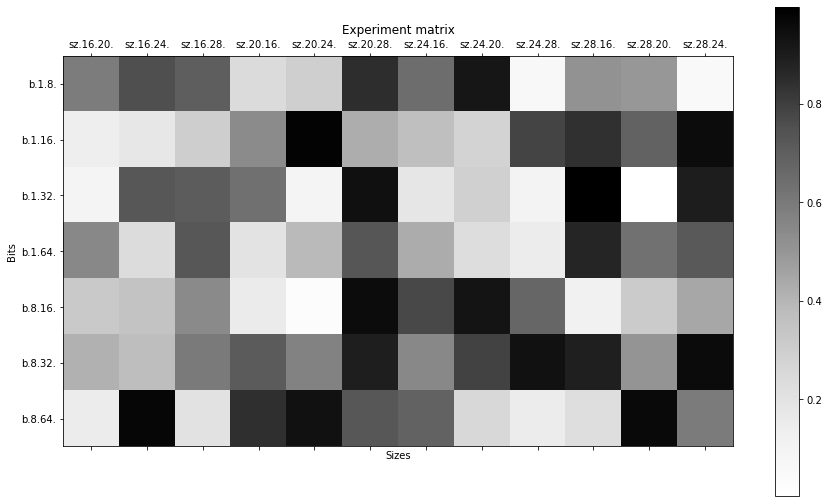

In [45]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import matplotlib.backends.backend_pdf as pdf
import tqdm

def save_figs(fn):
    print(f"-->  Saving all figures... {fn}")
    out_pdf = pdf.PdfPages(fn)
    for fig in tqdm.tqdm(range(1, plt.gcf().number+1)):
        out_pdf.savefig( fig )
    out_pdf.close()
    plt.close("all")


def plot_matrix(cm, title='Experiment matrix', cmap='Greys', xlabels=None, ylabels=None, cblabel=None):
    fig = plt.figure(figsize=(len(xlabels)*1.25, 2+ len(ylabels)))
    ax = fig.add_subplot(111)
    # ax.xaxis.set_major_locator(ticker.MultipleLocator(2))
    # ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    cax = ax.matshow(cm,cmap=cmap)
    plt.title(title)
    ax.set_xticks(range(len(xlabels)))
    ax.set_yticks(range(len(ylabels)))
    cbar = fig.colorbar(cax)

    if cblabel:
        cbar.set_label(cblabel)
    if xlabels:
        ax.set_xticklabels(list(xlabels))
    if ylabels:
        ax.set_yticklabels(list(ylabels))
    plt.xlabel('Sizes')
    plt.ylabel('Bits')
    #plt.show()


def make_maps(size, cfgs):
    bits_map = {}
    logsize_map = {}

    count_bits =0
    count_sizes = 0
    for c in cfgs :

        if len(c) ==size:
            if(not bits_str(c) in bits_map):
                bits_map[bits_str(c)] = count_bits
                count_bits+=1
            if(not logsize_str(c) in logsize_map):
                logsize_map[logsize_str(c)] = count_sizes
                count_sizes+=1
    return bits_map, logsize_map

bits_map, logsize_map = make_maps(2,cfgs)

print(len(bits_map), len(logsize_map))
print(bits_map)
print(logsize_map)
a = np.random.rand(len(bits_map), len(logsize_map))
plot_matrix(a, ylabels=bits_map.keys(), xlabels=logsize_map.keys())


In [46]:
def make_matrices(size, cfgs):
    bits_map, logsize_map = make_maps(size,cfgs)
    matrices= {}
    matrix_indices = ["err_mean_pc"]
    for shapen,shapef in polygon_sets:
        matrices[shapef] = {}
        for dn, ds in datasets :
            matrices[shapef][ds] = {}
            for mi in matrix_indices:
                matrices[shapef][ds][mi] = np.zeros((len(bits_map),(len(logsize_map))))-1



    x=0
    for c in cfgs :
        # print(fc_to_string(k,c))
        y = 0;
        for shpn, shapef in polygon_sets:
            for  dn, ds in datasets :
                fn = experiments_path + exp_name + "/" + exp_name + f'.w{width}h{height}.{x:04d}.{y}-' + fc_to_string(k,c) \
                + ds + "." + shapef + ".json"
                # print(fn)
                data = load_exp(fn)
                bits = bits_str(c)
                sz = logsize_str(c)
                if data and bits in bits_map and  sz in logsize_map:
                    for mi in matrix_indices:
                        matrices[shapef][ds][mi][ bits_map[bits],logsize_map[sz]] = data[mi]
            y+=1
        x+=1

    for shpn, shapef in polygon_sets:
        for  dn, ds in datasets :
            for mi in matrix_indices:   
                plot_matrix( matrices[shapef][ds][mi] ,title=f'{dn} - {shpn}',ylabels=bits_map.keys(), xlabels=logsize_map.keys(), cblabel="% Error")             

make_matrices(1, cfgs)   
make_matrices(2, cfgs)              
make_matrices(3, cfgs)              


save_figs("polygons_test_matrices.pdf")

[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0000.0-k_8bits_1.logsize_16.twitter_100mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0000.0-k_8bits_1.logsize_16.twitter_100mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0000.0-k_8bits_1.logsize_16.asia_100mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0000.0-k_8bits_1.logsize_16.asia_200mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0000.0-k_8bits_1.logsize_16.asia_500mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0000.0-k_8bits_1.logsize_16.asia_1bil_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../t

[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0165.0-k_8bits_1.8.32.logsize_20.24.28.twitter_100mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0165.0-k_8bits_1.8.32.logsize_20.24.28.asia_100mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0165.0-k_8bits_1.8.32.logsize_20.24.28.asia_200mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0165.0-k_8bits_1.8.32.logsize_20.24.28.asia_500mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0165.0-k_8bits_1.8.32.logsize_20.24.28.asia_1bil_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0165.1-k_8bits_1.8.32.logsize_20.24.28.twitter_100mio_coords.h5.G

[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0338.0-k_8bits_8.16.64.logsize_28.16.20.asia_1bil_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0338.1-k_8bits_8.16.64.logsize_28.16.20.twitter_100mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0338.1-k_8bits_8.16.64.logsize_28.16.20.twitter_100mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0338.1-k_8bits_8.16.64.logsize_28.16.20.asia_100mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0338.1-k_8bits_8.16.64.logsize_28.16.20.asia_200mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0338.1-k_8bit

[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0000.0-k_8bits_1.logsize_16.twitter_100mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0000.0-k_8bits_1.logsize_16.twitter_100mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0000.0-k_8bits_1.logsize_16.asia_100mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0000.0-k_8bits_1.logsize_16.asia_200mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0000.0-k_8bits_1.logsize_16.asia_500mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0000.0-k_8bits_1.logsize_16.asia_1bil_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../t

[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0174.1-k_8bits_8.16.logsize_20.24.asia_500mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0174.1-k_8bits_8.16.logsize_20.24.asia_1bil_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0175.0-k_8bits_8.16.32.logsize_20.24.28.twitter_100mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0175.0-k_8bits_8.16.32.logsize_20.24.28.twitter_100mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0175.0-k_8bits_8.16.32.logsize_20.24.28.asia_100mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0175.0-k_8bits_8.16.32.logsize_20.24.28.asia_20

[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0352.0-k_8bits_1.64.logsize_28.16.asia_100mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0352.0-k_8bits_1.64.logsize_28.16.asia_200mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0352.0-k_8bits_1.64.logsize_28.16.asia_500mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0352.0-k_8bits_1.64.logsize_28.16.asia_1bil_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0352.1-k_8bits_1.64.logsize_28.16.twitter_100mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0352.1-k_8bits_1.64.logsize_28.16.twitter_100mio_coords.h5.Global_LSIB_Polygons

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0000.0-k_8bits_1.logsize_16.twitter_100mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0000.0-k_8bits_1.logsize_16.twitter_100mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0000.0-k_8bits_1.logsize_16.asia_100mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0000.0-k_8bits_1.logsize_16.asia_200mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0000.0-k_8bits_1.logsize_16.asia_500mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0000.0-k_8bits_1.logsize_16.asia_1bil_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../t

[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0174.0-k_8bits_8.16.logsize_20.24.twitter_100mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0174.0-k_8bits_8.16.logsize_20.24.asia_100mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0174.0-k_8bits_8.16.logsize_20.24.asia_200mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0174.0-k_8bits_8.16.logsize_20.24.asia_500mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0174.0-k_8bits_8.16.logsize_20.24.asia_1bil_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0174.1-k_8bits_8.16.logsize_20.24.twitter_100mio_coords.h5.Global_LSIB_Polygons_Detailed.j

[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0345.0-k_8bits_1.8.32.logsize_28.16.24.twitter_100mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0345.0-k_8bits_1.8.32.logsize_28.16.24.asia_100mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0345.0-k_8bits_1.8.32.logsize_28.16.24.asia_200mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0345.0-k_8bits_1.8.32.logsize_28.16.24.asia_500mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0345.0-k_8bits_1.8.32.logsize_28.16.24.asia_1bil_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0345.1-k_8bits_1.8.32.logsize_28.16.24.twitter_100mio_coords.h5.G

-->  Saving all figures... polygons_test_matrices.pdf


100%|██████████| 48/48 [00:03<00:00, 15.51it/s]


In [61]:
import numpy as np
import math
from matplotlib import pyplot as plt
import matplotlib.backends.backend_pdf as pdf
from mpl_toolkits.mplot3d import axes3d
figsize= (8,8)
def plot_hist(data, title="title", xlab="x", ylab="y", bins=20, log=False):
    plt.figure(figsize=figsize)
    bins = np.linspace(math.ceil(min(data)), 
                       math.floor(max(data)),
                       bins) # fixed number of bins

    plt.xlim([min(data)-5, max(data)+5])

    if(log):
        plt.hist(np.log10(data), bins=bins, alpha=0.5)
        
    else:
        plt.hist(data, bins=bins, alpha=0.5)
    plt.title(title)
    plt.xlabel(xlab)
    plt.ylabel(ylab)
    plt.show()

In [78]:
from scipy import signal
from PIL import Image
def make_hist(size, cfgs):
    bits_map, logsize_map = make_maps(size,cfgs)
    matrices= {}
    matrix_indices = ["histogram_pc"]
    for shapen,shapef in polygon_sets:
        matrices[shapef] = {}
        for dn, ds in datasets :
            matrices[shapef][ds] = {}
            for mi in matrix_indices:
                matrices[shapef][ds][mi] = np.zeros((len(bits_map),(len(logsize_map))))-1



    x=0
    for c in cfgs :
        # print(fc_to_string(k,c))
        y = 0;
        for shpn, shapef in polygon_sets:
            for  dn, ds in datasets :
                fn = experiments_path + exp_name + "/" + exp_name + f'.w{width}h{height}.{x:04d}.{y}-' + fc_to_string(k,c) \
                + ds + "." + shapef + ".json"
                # print(fn)
                data = load_exp(fn)
                bits = bits_str(c)
                sz = logsize_str(c)
                if data and bits in bits_map and  sz in logsize_map:
                    for mi in matrix_indices:
                        p =  np.abs(data[mi]) #scipy.signal.resample(data[mi], 100)
                        ##p = np.array(Image.fromarray(data[mi]).resize(100,1))
                        #print(p)
                        plt.figure(figsize=figsize)
                        plt.bar(list(np.arange(0,100,100/len(p))),p)
                        plt.title(f'{dn} - {shpn} b{bits} sz{sz}')
                        #plt.show()

            y+=1
        x+=1

   # for shpn, shapef in polygon_sets:
   #     for  dn, ds in datasets :
   #         for mi in matrix_indices:   
   #             print(matrices[shapef][ds][mi])
make_hist(1,cfgs)
save_figs("polygons_test_hist1.pdf")
make_hist(2,cfgs)
save_figs("polygons_test_hist2.pdf")
make_hist(3,cfgs)
save_figs("polygons_test_hist3.pdf")

[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0000.0-k_8bits_1.logsize_16.twitter_100mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0000.0-k_8bits_1.logsize_16.twitter_100mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0000.0-k_8bits_1.logsize_16.asia_100mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0000.0-k_8bits_1.logsize_16.asia_200mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0000.0-k_8bits_1.logsize_16.asia_500mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0000.0-k_8bits_1.logsize_16.asia_1bil_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../t

[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0011.0-k_8bits_8.logsize_16.twitter_100mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0011.0-k_8bits_8.logsize_16.twitter_100mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0011.0-k_8bits_8.logsize_16.asia_100mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0011.0-k_8bits_8.logsize_16.asia_200mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0011.0-k_8bits_8.logsize_16.asia_500mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0011.0-k_8bits_8.logsize_16.asia_1bil_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../t

[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0018.0-k_8bits_1.logsize_16.twitter_100mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0018.0-k_8bits_1.logsize_16.twitter_100mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0018.0-k_8bits_1.logsize_16.asia_100mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0018.0-k_8bits_1.logsize_16.asia_200mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0018.0-k_8bits_1.logsize_16.asia_500mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0018.0-k_8bits_1.logsize_16.asia_1bil_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../t

[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0029.0-k_8bits_8.logsize_16.twitter_100mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0029.0-k_8bits_8.logsize_16.twitter_100mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0029.0-k_8bits_8.logsize_16.asia_100mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0029.0-k_8bits_8.logsize_16.asia_200mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0029.0-k_8bits_8.logsize_16.asia_500mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0029.0-k_8bits_8.logsize_16.asia_1bil_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../t

[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0036.0-k_8bits_1.logsize_16.twitter_100mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0036.0-k_8bits_1.logsize_16.twitter_100mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0036.0-k_8bits_1.logsize_16.asia_100mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0036.0-k_8bits_1.logsize_16.asia_200mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0036.0-k_8bits_1.logsize_16.asia_500mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0036.0-k_8bits_1.logsize_16.asia_1bil_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../t

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:33: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0047.0-k_8bits_8.logsize_16.twitter_100mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0047.0-k_8bits_8.logsize_16.twitter_100mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0047.0-k_8bits_8.logsize_16.asia_100mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0047.0-k_8bits_8.logsize_16.asia_200mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0047.0-k_8bits_8.logsize_16.asia_500mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0047.0-k_8bits_8.logsize_16.asia_1bil_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../t

[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0054.0-k_8bits_1.logsize_16.twitter_100mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0054.0-k_8bits_1.logsize_16.twitter_100mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0054.0-k_8bits_1.logsize_16.asia_100mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0054.0-k_8bits_1.logsize_16.asia_200mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0054.0-k_8bits_1.logsize_16.asia_500mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0054.0-k_8bits_1.logsize_16.asia_1bil_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../t

[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0065.0-k_8bits_8.logsize_16.twitter_100mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0065.0-k_8bits_8.logsize_16.twitter_100mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0065.0-k_8bits_8.logsize_16.asia_100mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0065.0-k_8bits_8.logsize_16.asia_200mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0065.0-k_8bits_8.logsize_16.asia_500mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0065.0-k_8bits_8.logsize_16.asia_1bil_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../t

[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0072.0-k_8bits_1.logsize_16.twitter_100mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0072.0-k_8bits_1.logsize_16.twitter_100mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0072.0-k_8bits_1.logsize_16.asia_100mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0072.0-k_8bits_1.logsize_16.asia_200mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0072.0-k_8bits_1.logsize_16.asia_500mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0072.0-k_8bits_1.logsize_16.asia_1bil_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../t

[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0083.0-k_8bits_8.logsize_16.twitter_100mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0083.0-k_8bits_8.logsize_16.twitter_100mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0083.0-k_8bits_8.logsize_16.asia_100mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0083.0-k_8bits_8.logsize_16.asia_200mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0083.0-k_8bits_8.logsize_16.asia_500mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0083.0-k_8bits_8.logsize_16.asia_1bil_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../t

[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0090.0-k_8bits_1.logsize_16.twitter_100mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0090.0-k_8bits_1.logsize_16.twitter_100mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0090.0-k_8bits_1.logsize_16.asia_100mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0090.0-k_8bits_1.logsize_16.asia_200mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0090.0-k_8bits_1.logsize_16.asia_500mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0090.0-k_8bits_1.logsize_16.asia_1bil_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../t

[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0101.0-k_8bits_8.logsize_16.twitter_100mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0101.0-k_8bits_8.logsize_16.twitter_100mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0101.0-k_8bits_8.logsize_16.asia_100mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0101.0-k_8bits_8.logsize_16.asia_200mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0101.0-k_8bits_8.logsize_16.asia_500mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0101.0-k_8bits_8.logsize_16.asia_1bil_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../t

[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0108.0-k_8bits_1.logsize_20.twitter_100mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0108.0-k_8bits_1.logsize_20.twitter_100mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0108.0-k_8bits_1.logsize_20.asia_100mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0108.0-k_8bits_1.logsize_20.asia_200mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0108.0-k_8bits_1.logsize_20.asia_500mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0108.0-k_8bits_1.logsize_20.asia_1bil_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../t

[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0119.0-k_8bits_8.logsize_20.twitter_100mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0119.0-k_8bits_8.logsize_20.twitter_100mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0119.0-k_8bits_8.logsize_20.asia_100mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0119.0-k_8bits_8.logsize_20.asia_200mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0119.0-k_8bits_8.logsize_20.asia_500mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0119.0-k_8bits_8.logsize_20.asia_1bil_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../t

[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0126.0-k_8bits_1.logsize_20.twitter_100mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0126.0-k_8bits_1.logsize_20.twitter_100mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0126.0-k_8bits_1.logsize_20.asia_100mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0126.0-k_8bits_1.logsize_20.asia_200mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0126.0-k_8bits_1.logsize_20.asia_500mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0126.0-k_8bits_1.logsize_20.asia_1bil_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../t

[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0137.0-k_8bits_8.logsize_20.twitter_100mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0137.0-k_8bits_8.logsize_20.twitter_100mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0137.0-k_8bits_8.logsize_20.asia_100mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0137.0-k_8bits_8.logsize_20.asia_200mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0137.0-k_8bits_8.logsize_20.asia_500mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0137.0-k_8bits_8.logsize_20.asia_1bil_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../t

[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0144.0-k_8bits_1.logsize_20.twitter_100mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0144.0-k_8bits_1.logsize_20.twitter_100mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0144.0-k_8bits_1.logsize_20.asia_100mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0144.0-k_8bits_1.logsize_20.asia_200mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0144.0-k_8bits_1.logsize_20.asia_500mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0144.0-k_8bits_1.logsize_20.asia_1bil_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../t

[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0155.0-k_8bits_8.logsize_20.twitter_100mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0155.0-k_8bits_8.logsize_20.twitter_100mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0155.0-k_8bits_8.logsize_20.asia_100mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0155.0-k_8bits_8.logsize_20.asia_200mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0155.0-k_8bits_8.logsize_20.asia_500mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0155.0-k_8bits_8.logsize_20.asia_1bil_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../t

[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0162.0-k_8bits_1.logsize_20.twitter_100mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0162.0-k_8bits_1.logsize_20.twitter_100mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0162.0-k_8bits_1.logsize_20.asia_100mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0162.0-k_8bits_1.logsize_20.asia_200mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0162.0-k_8bits_1.logsize_20.asia_500mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0162.0-k_8bits_1.logsize_20.asia_1bil_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../t

[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0173.0-k_8bits_8.logsize_20.twitter_100mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0173.0-k_8bits_8.logsize_20.twitter_100mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0173.0-k_8bits_8.logsize_20.asia_100mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0173.0-k_8bits_8.logsize_20.asia_200mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0173.0-k_8bits_8.logsize_20.asia_500mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0173.0-k_8bits_8.logsize_20.asia_1bil_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../t

[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0180.0-k_8bits_1.logsize_20.twitter_100mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0180.0-k_8bits_1.logsize_20.twitter_100mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0180.0-k_8bits_1.logsize_20.asia_100mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0180.0-k_8bits_1.logsize_20.asia_200mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0180.0-k_8bits_1.logsize_20.asia_500mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0180.0-k_8bits_1.logsize_20.asia_1bil_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../t

[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0191.0-k_8bits_8.logsize_20.twitter_100mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0191.0-k_8bits_8.logsize_20.twitter_100mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0191.0-k_8bits_8.logsize_20.asia_100mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0191.0-k_8bits_8.logsize_20.asia_200mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0191.0-k_8bits_8.logsize_20.asia_500mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0191.0-k_8bits_8.logsize_20.asia_1bil_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../t

[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0198.0-k_8bits_1.logsize_20.twitter_100mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0198.0-k_8bits_1.logsize_20.twitter_100mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0198.0-k_8bits_1.logsize_20.asia_100mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0198.0-k_8bits_1.logsize_20.asia_200mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0198.0-k_8bits_1.logsize_20.asia_500mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0198.0-k_8bits_1.logsize_20.asia_1bil_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../t

[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0209.0-k_8bits_8.logsize_20.twitter_100mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0209.0-k_8bits_8.logsize_20.twitter_100mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0209.0-k_8bits_8.logsize_20.asia_100mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0209.0-k_8bits_8.logsize_20.asia_200mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0209.0-k_8bits_8.logsize_20.asia_500mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0209.0-k_8bits_8.logsize_20.asia_1bil_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../t

[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0216.0-k_8bits_1.logsize_24.twitter_100mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0216.0-k_8bits_1.logsize_24.twitter_100mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0216.0-k_8bits_1.logsize_24.asia_100mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0216.0-k_8bits_1.logsize_24.asia_200mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0216.0-k_8bits_1.logsize_24.asia_500mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0216.0-k_8bits_1.logsize_24.asia_1bil_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../t

[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0227.0-k_8bits_8.logsize_24.twitter_100mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0227.0-k_8bits_8.logsize_24.twitter_100mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0227.0-k_8bits_8.logsize_24.asia_100mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0227.0-k_8bits_8.logsize_24.asia_200mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0227.0-k_8bits_8.logsize_24.asia_500mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0227.0-k_8bits_8.logsize_24.asia_1bil_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../t

[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0234.0-k_8bits_1.logsize_24.twitter_100mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0234.0-k_8bits_1.logsize_24.twitter_100mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0234.0-k_8bits_1.logsize_24.asia_100mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0234.0-k_8bits_1.logsize_24.asia_200mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0234.0-k_8bits_1.logsize_24.asia_500mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0234.0-k_8bits_1.logsize_24.asia_1bil_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../t

[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0245.0-k_8bits_8.logsize_24.twitter_100mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0245.0-k_8bits_8.logsize_24.twitter_100mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0245.0-k_8bits_8.logsize_24.asia_100mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0245.0-k_8bits_8.logsize_24.asia_200mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0245.0-k_8bits_8.logsize_24.asia_500mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0245.0-k_8bits_8.logsize_24.asia_1bil_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../t

[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0252.0-k_8bits_1.logsize_24.twitter_100mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0252.0-k_8bits_1.logsize_24.twitter_100mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0252.0-k_8bits_1.logsize_24.asia_100mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0252.0-k_8bits_1.logsize_24.asia_200mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0252.0-k_8bits_1.logsize_24.asia_500mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0252.0-k_8bits_1.logsize_24.asia_1bil_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../t

[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0263.0-k_8bits_8.logsize_24.twitter_100mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0263.0-k_8bits_8.logsize_24.twitter_100mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0263.0-k_8bits_8.logsize_24.asia_100mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0263.0-k_8bits_8.logsize_24.asia_200mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0263.0-k_8bits_8.logsize_24.asia_500mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0263.0-k_8bits_8.logsize_24.asia_1bil_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../t

[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0270.0-k_8bits_1.logsize_24.twitter_100mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0270.0-k_8bits_1.logsize_24.twitter_100mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0270.0-k_8bits_1.logsize_24.asia_100mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0270.0-k_8bits_1.logsize_24.asia_200mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0270.0-k_8bits_1.logsize_24.asia_500mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0270.0-k_8bits_1.logsize_24.asia_1bil_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../t

[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0281.0-k_8bits_8.logsize_24.twitter_100mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0281.0-k_8bits_8.logsize_24.twitter_100mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0281.0-k_8bits_8.logsize_24.asia_100mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0281.0-k_8bits_8.logsize_24.asia_200mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0281.0-k_8bits_8.logsize_24.asia_500mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0281.0-k_8bits_8.logsize_24.asia_1bil_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../t

[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0288.0-k_8bits_1.logsize_24.twitter_100mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0288.0-k_8bits_1.logsize_24.twitter_100mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0288.0-k_8bits_1.logsize_24.asia_100mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0288.0-k_8bits_1.logsize_24.asia_200mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0288.0-k_8bits_1.logsize_24.asia_500mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0288.0-k_8bits_1.logsize_24.asia_1bil_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../t

[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0299.0-k_8bits_8.logsize_24.twitter_100mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0299.0-k_8bits_8.logsize_24.twitter_100mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0299.0-k_8bits_8.logsize_24.asia_100mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0299.0-k_8bits_8.logsize_24.asia_200mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0299.0-k_8bits_8.logsize_24.asia_500mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0299.0-k_8bits_8.logsize_24.asia_1bil_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../t

[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0306.0-k_8bits_1.logsize_24.twitter_100mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0306.0-k_8bits_1.logsize_24.twitter_100mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0306.0-k_8bits_1.logsize_24.asia_100mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0306.0-k_8bits_1.logsize_24.asia_200mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0306.0-k_8bits_1.logsize_24.asia_500mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0306.0-k_8bits_1.logsize_24.asia_1bil_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../t

[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0317.0-k_8bits_8.logsize_24.twitter_100mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0317.0-k_8bits_8.logsize_24.twitter_100mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0317.0-k_8bits_8.logsize_24.asia_100mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0317.0-k_8bits_8.logsize_24.asia_200mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0317.0-k_8bits_8.logsize_24.asia_500mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0317.0-k_8bits_8.logsize_24.asia_1bil_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../t

[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0324.0-k_8bits_1.logsize_28.twitter_100mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0324.0-k_8bits_1.logsize_28.twitter_100mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0324.0-k_8bits_1.logsize_28.asia_100mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0324.0-k_8bits_1.logsize_28.asia_200mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0324.0-k_8bits_1.logsize_28.asia_500mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0324.0-k_8bits_1.logsize_28.asia_1bil_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../t

[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0335.0-k_8bits_8.logsize_28.twitter_100mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0335.0-k_8bits_8.logsize_28.twitter_100mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0335.0-k_8bits_8.logsize_28.asia_100mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0335.0-k_8bits_8.logsize_28.asia_200mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0335.0-k_8bits_8.logsize_28.asia_500mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0335.0-k_8bits_8.logsize_28.asia_1bil_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../t

[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0342.0-k_8bits_1.logsize_28.twitter_100mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0342.0-k_8bits_1.logsize_28.twitter_100mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0342.0-k_8bits_1.logsize_28.asia_100mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0342.0-k_8bits_1.logsize_28.asia_200mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0342.0-k_8bits_1.logsize_28.asia_500mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0342.0-k_8bits_1.logsize_28.asia_1bil_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../t

[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0353.0-k_8bits_8.logsize_28.twitter_100mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0353.0-k_8bits_8.logsize_28.twitter_100mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0353.0-k_8bits_8.logsize_28.asia_100mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0353.0-k_8bits_8.logsize_28.asia_200mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0353.0-k_8bits_8.logsize_28.asia_500mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0353.0-k_8bits_8.logsize_28.asia_1bil_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../t

[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0360.0-k_8bits_1.logsize_28.twitter_100mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0360.0-k_8bits_1.logsize_28.twitter_100mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0360.0-k_8bits_1.logsize_28.asia_100mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0360.0-k_8bits_1.logsize_28.asia_200mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0360.0-k_8bits_1.logsize_28.asia_500mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0360.0-k_8bits_1.logsize_28.asia_1bil_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../t

[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0371.0-k_8bits_8.logsize_28.twitter_100mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0371.0-k_8bits_8.logsize_28.twitter_100mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0371.0-k_8bits_8.logsize_28.asia_100mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0371.0-k_8bits_8.logsize_28.asia_200mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0371.0-k_8bits_8.logsize_28.asia_500mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0371.0-k_8bits_8.logsize_28.asia_1bil_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../t

[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0378.0-k_8bits_1.logsize_28.twitter_100mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0378.0-k_8bits_1.logsize_28.twitter_100mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0378.0-k_8bits_1.logsize_28.asia_100mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0378.0-k_8bits_1.logsize_28.asia_200mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0378.0-k_8bits_1.logsize_28.asia_500mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0378.0-k_8bits_1.logsize_28.asia_1bil_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../t

[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0389.0-k_8bits_8.logsize_28.twitter_100mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0389.0-k_8bits_8.logsize_28.twitter_100mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0389.0-k_8bits_8.logsize_28.asia_100mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0389.0-k_8bits_8.logsize_28.asia_200mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0389.0-k_8bits_8.logsize_28.asia_500mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0389.0-k_8bits_8.logsize_28.asia_1bil_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../t

[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0396.0-k_8bits_1.logsize_28.twitter_100mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0396.0-k_8bits_1.logsize_28.twitter_100mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0396.0-k_8bits_1.logsize_28.asia_100mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0396.0-k_8bits_1.logsize_28.asia_200mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0396.0-k_8bits_1.logsize_28.asia_500mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0396.0-k_8bits_1.logsize_28.asia_1bil_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../t

[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0407.0-k_8bits_8.logsize_28.twitter_100mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0407.0-k_8bits_8.logsize_28.twitter_100mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0407.0-k_8bits_8.logsize_28.asia_100mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0407.0-k_8bits_8.logsize_28.asia_200mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0407.0-k_8bits_8.logsize_28.asia_500mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0407.0-k_8bits_8.logsize_28.asia_1bil_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../t

[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0414.1-k_8bits_1.logsize_28.twitter_100mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0414.1-k_8bits_1.logsize_28.twitter_100mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0414.1-k_8bits_1.logsize_28.asia_100mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0414.1-k_8bits_1.logsize_28.asia_200mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0414.1-k_8bits_1.logsize_28.asia_500mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0414.1-k_8bits_1.logsize_28.asia_1bil_coords.h5.Global_LSIB_

[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0425.1-k_8bits_8.logsize_28.twitter_100mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0425.1-k_8bits_8.logsize_28.twitter_100mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0425.1-k_8bits_8.logsize_28.asia_100mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0425.1-k_8bits_8.logsize_28.asia_200mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0425.1-k_8bits_8.logsize_28.asia_500mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0425.1-k_8bits_8.logsize_28.asia_1bil_coords.h5.Global_LSIB_

100%|██████████| 192/192 [00:11<00:00, 16.13it/s]


[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0000.0-k_8bits_1.logsize_16.twitter_100mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0000.0-k_8bits_1.logsize_16.twitter_100mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0000.0-k_8bits_1.logsize_16.asia_100mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0000.0-k_8bits_1.logsize_16.asia_200mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0000.0-k_8bits_1.logsize_16.asia_500mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0000.0-k_8bits_1.logsize_16.asia_1bil_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../t

[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0005.1-k_8bits_1.16.logsize_16.20.twitter_100mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0005.1-k_8bits_1.16.logsize_16.20.twitter_100mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0005.1-k_8bits_1.16.logsize_16.20.asia_100mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0005.1-k_8bits_1.16.logsize_16.20.asia_200mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0005.1-k_8bits_1.16.logsize_16.20.asia_500mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0005.1-k_8bits_1.16.logsize_16

[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0010.1-k_8bits_1.64.logsize_16.20.twitter_100mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0010.1-k_8bits_1.64.logsize_16.20.twitter_100mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0010.1-k_8bits_1.64.logsize_16.20.asia_100mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0010.1-k_8bits_1.64.logsize_16.20.asia_200mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0010.1-k_8bits_1.64.logsize_16.20.asia_500mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0010.1-k_8bits_1.64.logsize_16

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:33: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0015.1-k_8bits_8.32.logsize_16.20.twitter_100mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0015.1-k_8bits_8.32.logsize_16.20.twitter_100mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0015.1-k_8bits_8.32.logsize_16.20.asia_100mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0015.1-k_8bits_8.32.logsize_16.20.asia_200mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0015.1-k_8bits_8.32.logsize_16.20.asia_500mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0015.1-k_8bits_8.32.logsize_16

[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0023.0-k_8bits_1.16.logsize_16.20.twitter_100mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0023.0-k_8bits_1.16.logsize_16.20.twitter_100mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0023.0-k_8bits_1.16.logsize_16.20.asia_100mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0023.0-k_8bits_1.16.logsize_16.20.asia_200mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0023.0-k_8bits_1.16.logsize_16.20.asia_500mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0023.0-k_8bits_1.16.logsize_16.20.asia_1bil_coords.h5.tl_2017_us_zcta510.json'
[Errno

[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0028.0-k_8bits_1.64.logsize_16.20.twitter_100mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0028.0-k_8bits_1.64.logsize_16.20.twitter_100mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0028.0-k_8bits_1.64.logsize_16.20.asia_100mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0028.0-k_8bits_1.64.logsize_16.20.asia_200mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0028.0-k_8bits_1.64.logsize_16.20.asia_500mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0028.0-k_8bits_1.64.logsize_16.20.asia_1bil_coords.h5.tl_2017_us_zcta510.json'
[Errno

[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0033.0-k_8bits_8.32.logsize_16.20.twitter_100mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0033.0-k_8bits_8.32.logsize_16.20.twitter_100mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0033.0-k_8bits_8.32.logsize_16.20.asia_100mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0033.0-k_8bits_8.32.logsize_16.20.asia_200mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0033.0-k_8bits_8.32.logsize_16.20.asia_500mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0033.0-k_8bits_8.32.logsize_16.20.asia_1bil_coords.h5.tl_2017_us_zcta510.json'
[Errno

[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0037.0-k_8bits_1.8.logsize_16.24.twitter_100mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0037.0-k_8bits_1.8.logsize_16.24.twitter_100mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0037.0-k_8bits_1.8.logsize_16.24.asia_100mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0037.0-k_8bits_1.8.logsize_16.24.asia_200mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0037.0-k_8bits_1.8.logsize_16.24.asia_500mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0037.0-k_8bits_1.8.logsize_16.24.asia_1bil_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No

[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0041.0-k_8bits_1.16.logsize_16.24.twitter_100mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0041.0-k_8bits_1.16.logsize_16.24.twitter_100mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0041.0-k_8bits_1.16.logsize_16.24.asia_100mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0041.0-k_8bits_1.16.logsize_16.24.asia_200mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0041.0-k_8bits_1.16.logsize_16.24.asia_500mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0041.0-k_8bits_1.16.logsize_16.24.asia_1bil_coords.h5.tl_2017_us_zcta510.json'
[Errno

[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0046.0-k_8bits_1.64.logsize_16.24.twitter_100mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0046.0-k_8bits_1.64.logsize_16.24.twitter_100mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0046.0-k_8bits_1.64.logsize_16.24.asia_100mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0046.0-k_8bits_1.64.logsize_16.24.asia_200mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0046.0-k_8bits_1.64.logsize_16.24.asia_500mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0046.0-k_8bits_1.64.logsize_16.24.asia_1bil_coords.h5.tl_2017_us_zcta510.json'
[Errno

[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0051.0-k_8bits_8.32.logsize_16.24.twitter_100mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0051.0-k_8bits_8.32.logsize_16.24.twitter_100mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0051.0-k_8bits_8.32.logsize_16.24.asia_100mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0051.0-k_8bits_8.32.logsize_16.24.asia_200mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0051.0-k_8bits_8.32.logsize_16.24.asia_500mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0051.0-k_8bits_8.32.logsize_16.24.asia_1bil_coords.h5.tl_2017_us_zcta510.json'
[Errno

[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0055.0-k_8bits_1.8.logsize_16.24.twitter_100mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0055.0-k_8bits_1.8.logsize_16.24.twitter_100mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0055.0-k_8bits_1.8.logsize_16.24.asia_100mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0055.0-k_8bits_1.8.logsize_16.24.asia_200mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0055.0-k_8bits_1.8.logsize_16.24.asia_500mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0055.0-k_8bits_1.8.logsize_16.24.asia_1bil_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No

[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0059.1-k_8bits_1.16.logsize_16.24.twitter_100mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0059.1-k_8bits_1.16.logsize_16.24.twitter_100mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0059.1-k_8bits_1.16.logsize_16.24.asia_100mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0059.1-k_8bits_1.16.logsize_16.24.asia_200mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0059.1-k_8bits_1.16.logsize_16.24.asia_500mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0059.1-k_8bits_1.16.logsize_16

[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0064.1-k_8bits_1.64.logsize_16.24.twitter_100mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0064.1-k_8bits_1.64.logsize_16.24.twitter_100mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0064.1-k_8bits_1.64.logsize_16.24.asia_100mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0064.1-k_8bits_1.64.logsize_16.24.asia_200mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0064.1-k_8bits_1.64.logsize_16.24.asia_500mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0064.1-k_8bits_1.64.logsize_16

[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0069.1-k_8bits_8.32.logsize_16.24.twitter_100mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0069.1-k_8bits_8.32.logsize_16.24.twitter_100mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0069.1-k_8bits_8.32.logsize_16.24.asia_100mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0069.1-k_8bits_8.32.logsize_16.24.asia_200mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0069.1-k_8bits_8.32.logsize_16.24.asia_500mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0069.1-k_8bits_8.32.logsize_16

[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0073.1-k_8bits_1.8.logsize_16.28.twitter_100mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0073.1-k_8bits_1.8.logsize_16.28.twitter_100mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0073.1-k_8bits_1.8.logsize_16.28.asia_100mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0073.1-k_8bits_1.8.logsize_16.28.asia_200mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0073.1-k_8bits_1.8.logsize_16.28.asia_500mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0073.1-k_8bits_1.8.logsize_16.28.as

[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0077.1-k_8bits_1.16.logsize_16.28.twitter_100mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0077.1-k_8bits_1.16.logsize_16.28.twitter_100mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0077.1-k_8bits_1.16.logsize_16.28.asia_100mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0077.1-k_8bits_1.16.logsize_16.28.asia_200mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0077.1-k_8bits_1.16.logsize_16.28.asia_500mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0077.1-k_8bits_1.16.logsize_16

[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0082.1-k_8bits_1.64.logsize_16.28.twitter_100mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0082.1-k_8bits_1.64.logsize_16.28.twitter_100mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0082.1-k_8bits_1.64.logsize_16.28.asia_100mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0082.1-k_8bits_1.64.logsize_16.28.asia_200mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0082.1-k_8bits_1.64.logsize_16.28.asia_500mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0082.1-k_8bits_1.64.logsize_16

[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0087.1-k_8bits_8.32.logsize_16.28.twitter_100mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0087.1-k_8bits_8.32.logsize_16.28.twitter_100mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0087.1-k_8bits_8.32.logsize_16.28.asia_100mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0087.1-k_8bits_8.32.logsize_16.28.asia_200mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0087.1-k_8bits_8.32.logsize_16.28.asia_500mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0087.1-k_8bits_8.32.logsize_16

[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0091.1-k_8bits_1.8.logsize_16.28.twitter_100mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0091.1-k_8bits_1.8.logsize_16.28.twitter_100mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0091.1-k_8bits_1.8.logsize_16.28.asia_100mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0091.1-k_8bits_1.8.logsize_16.28.asia_200mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0091.1-k_8bits_1.8.logsize_16.28.asia_500mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0091.1-k_8bits_1.8.logsize_16.28.as

[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0095.1-k_8bits_1.16.logsize_16.28.twitter_100mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0095.1-k_8bits_1.16.logsize_16.28.twitter_100mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0095.1-k_8bits_1.16.logsize_16.28.asia_100mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0095.1-k_8bits_1.16.logsize_16.28.asia_200mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0095.1-k_8bits_1.16.logsize_16.28.asia_500mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0095.1-k_8bits_1.16.logsize_16

[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0100.1-k_8bits_1.64.logsize_16.28.twitter_100mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0100.1-k_8bits_1.64.logsize_16.28.twitter_100mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0100.1-k_8bits_1.64.logsize_16.28.asia_100mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0100.1-k_8bits_1.64.logsize_16.28.asia_200mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0100.1-k_8bits_1.64.logsize_16.28.asia_500mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0100.1-k_8bits_1.64.logsize_16

[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0105.1-k_8bits_8.32.logsize_16.28.twitter_100mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0105.1-k_8bits_8.32.logsize_16.28.twitter_100mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0105.1-k_8bits_8.32.logsize_16.28.asia_100mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0105.1-k_8bits_8.32.logsize_16.28.asia_200mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0105.1-k_8bits_8.32.logsize_16.28.asia_500mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0105.1-k_8bits_8.32.logsize_16

[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0109.1-k_8bits_1.8.logsize_20.16.twitter_100mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0109.1-k_8bits_1.8.logsize_20.16.twitter_100mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0109.1-k_8bits_1.8.logsize_20.16.asia_100mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0109.1-k_8bits_1.8.logsize_20.16.asia_200mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0109.1-k_8bits_1.8.logsize_20.16.asia_500mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0109.1-k_8bits_1.8.logsize_20.16.as

[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0113.1-k_8bits_1.16.logsize_20.16.twitter_100mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0113.1-k_8bits_1.16.logsize_20.16.twitter_100mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0113.1-k_8bits_1.16.logsize_20.16.asia_100mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0113.1-k_8bits_1.16.logsize_20.16.asia_200mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0113.1-k_8bits_1.16.logsize_20.16.asia_500mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0113.1-k_8bits_1.16.logsize_20

[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0118.1-k_8bits_1.64.logsize_20.16.twitter_100mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0118.1-k_8bits_1.64.logsize_20.16.twitter_100mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0118.1-k_8bits_1.64.logsize_20.16.asia_100mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0118.1-k_8bits_1.64.logsize_20.16.asia_200mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0118.1-k_8bits_1.64.logsize_20.16.asia_500mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0118.1-k_8bits_1.64.logsize_20

[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0123.1-k_8bits_8.32.logsize_20.16.twitter_100mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0123.1-k_8bits_8.32.logsize_20.16.twitter_100mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0123.1-k_8bits_8.32.logsize_20.16.asia_100mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0123.1-k_8bits_8.32.logsize_20.16.asia_200mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0123.1-k_8bits_8.32.logsize_20.16.asia_500mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0123.1-k_8bits_8.32.logsize_20

[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0127.1-k_8bits_1.8.logsize_20.16.twitter_100mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0127.1-k_8bits_1.8.logsize_20.16.twitter_100mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0127.1-k_8bits_1.8.logsize_20.16.asia_100mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0127.1-k_8bits_1.8.logsize_20.16.asia_200mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0127.1-k_8bits_1.8.logsize_20.16.asia_500mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0127.1-k_8bits_1.8.logsize_20.16.as

[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0131.1-k_8bits_1.16.logsize_20.16.twitter_100mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0131.1-k_8bits_1.16.logsize_20.16.twitter_100mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0131.1-k_8bits_1.16.logsize_20.16.asia_100mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0131.1-k_8bits_1.16.logsize_20.16.asia_200mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0131.1-k_8bits_1.16.logsize_20.16.asia_500mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0131.1-k_8bits_1.16.logsize_20

[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0136.1-k_8bits_1.64.logsize_20.16.twitter_100mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0136.1-k_8bits_1.64.logsize_20.16.twitter_100mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0136.1-k_8bits_1.64.logsize_20.16.asia_100mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0136.1-k_8bits_1.64.logsize_20.16.asia_200mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0136.1-k_8bits_1.64.logsize_20.16.asia_500mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0136.1-k_8bits_1.64.logsize_20

[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0141.1-k_8bits_8.32.logsize_20.16.twitter_100mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0141.1-k_8bits_8.32.logsize_20.16.twitter_100mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0141.1-k_8bits_8.32.logsize_20.16.asia_100mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0141.1-k_8bits_8.32.logsize_20.16.asia_200mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0141.1-k_8bits_8.32.logsize_20.16.asia_500mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0141.1-k_8bits_8.32.logsize_20

[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0145.1-k_8bits_1.8.logsize_20.24.twitter_100mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0145.1-k_8bits_1.8.logsize_20.24.twitter_100mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0145.1-k_8bits_1.8.logsize_20.24.asia_100mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0145.1-k_8bits_1.8.logsize_20.24.asia_200mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0145.1-k_8bits_1.8.logsize_20.24.asia_500mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0145.1-k_8bits_1.8.logsize_20.24.as

[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0149.1-k_8bits_1.16.logsize_20.24.twitter_100mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0149.1-k_8bits_1.16.logsize_20.24.twitter_100mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0149.1-k_8bits_1.16.logsize_20.24.asia_100mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0149.1-k_8bits_1.16.logsize_20.24.asia_200mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0149.1-k_8bits_1.16.logsize_20.24.asia_500mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0149.1-k_8bits_1.16.logsize_20

[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0154.1-k_8bits_1.64.logsize_20.24.twitter_100mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0154.1-k_8bits_1.64.logsize_20.24.twitter_100mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0154.1-k_8bits_1.64.logsize_20.24.asia_100mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0154.1-k_8bits_1.64.logsize_20.24.asia_200mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0154.1-k_8bits_1.64.logsize_20.24.asia_500mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0154.1-k_8bits_1.64.logsize_20

[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0159.1-k_8bits_8.32.logsize_20.24.twitter_100mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0159.1-k_8bits_8.32.logsize_20.24.twitter_100mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0159.1-k_8bits_8.32.logsize_20.24.asia_100mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0159.1-k_8bits_8.32.logsize_20.24.asia_200mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0159.1-k_8bits_8.32.logsize_20.24.asia_500mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0159.1-k_8bits_8.32.logsize_20

[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0163.1-k_8bits_1.8.logsize_20.24.twitter_100mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0163.1-k_8bits_1.8.logsize_20.24.twitter_100mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0163.1-k_8bits_1.8.logsize_20.24.asia_100mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0163.1-k_8bits_1.8.logsize_20.24.asia_200mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0163.1-k_8bits_1.8.logsize_20.24.asia_500mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0163.1-k_8bits_1.8.logsize_20.24.as

[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0167.1-k_8bits_1.16.logsize_20.24.twitter_100mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0167.1-k_8bits_1.16.logsize_20.24.twitter_100mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0167.1-k_8bits_1.16.logsize_20.24.asia_100mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0167.1-k_8bits_1.16.logsize_20.24.asia_200mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0167.1-k_8bits_1.16.logsize_20.24.asia_500mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0167.1-k_8bits_1.16.logsize_20

[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0172.1-k_8bits_1.64.logsize_20.24.twitter_100mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0172.1-k_8bits_1.64.logsize_20.24.twitter_100mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0172.1-k_8bits_1.64.logsize_20.24.asia_100mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0172.1-k_8bits_1.64.logsize_20.24.asia_200mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0172.1-k_8bits_1.64.logsize_20.24.asia_500mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0172.1-k_8bits_1.64.logsize_20

[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0177.1-k_8bits_8.32.logsize_20.24.twitter_100mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0177.1-k_8bits_8.32.logsize_20.24.twitter_100mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0177.1-k_8bits_8.32.logsize_20.24.asia_100mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0177.1-k_8bits_8.32.logsize_20.24.asia_200mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0177.1-k_8bits_8.32.logsize_20.24.asia_500mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0177.1-k_8bits_8.32.logsize_20

[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0181.1-k_8bits_1.8.logsize_20.28.twitter_100mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0181.1-k_8bits_1.8.logsize_20.28.twitter_100mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0181.1-k_8bits_1.8.logsize_20.28.asia_100mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0181.1-k_8bits_1.8.logsize_20.28.asia_200mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0181.1-k_8bits_1.8.logsize_20.28.asia_500mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0181.1-k_8bits_1.8.logsize_20.28.as

[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0185.1-k_8bits_1.16.logsize_20.28.twitter_100mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0185.1-k_8bits_1.16.logsize_20.28.twitter_100mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0185.1-k_8bits_1.16.logsize_20.28.asia_100mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0185.1-k_8bits_1.16.logsize_20.28.asia_200mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0185.1-k_8bits_1.16.logsize_20.28.asia_500mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0185.1-k_8bits_1.16.logsize_20

[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0190.1-k_8bits_1.64.logsize_20.28.twitter_100mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0190.1-k_8bits_1.64.logsize_20.28.twitter_100mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0190.1-k_8bits_1.64.logsize_20.28.asia_100mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0190.1-k_8bits_1.64.logsize_20.28.asia_200mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0190.1-k_8bits_1.64.logsize_20.28.asia_500mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0190.1-k_8bits_1.64.logsize_20

[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0195.1-k_8bits_8.32.logsize_20.28.twitter_100mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0195.1-k_8bits_8.32.logsize_20.28.twitter_100mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0195.1-k_8bits_8.32.logsize_20.28.asia_100mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0195.1-k_8bits_8.32.logsize_20.28.asia_200mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0195.1-k_8bits_8.32.logsize_20.28.asia_500mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0195.1-k_8bits_8.32.logsize_20

[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0199.1-k_8bits_1.8.logsize_20.28.twitter_100mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0199.1-k_8bits_1.8.logsize_20.28.twitter_100mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0199.1-k_8bits_1.8.logsize_20.28.asia_100mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0199.1-k_8bits_1.8.logsize_20.28.asia_200mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0199.1-k_8bits_1.8.logsize_20.28.asia_500mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0199.1-k_8bits_1.8.logsize_20.28.as

[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0203.1-k_8bits_1.16.logsize_20.28.twitter_100mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0203.1-k_8bits_1.16.logsize_20.28.twitter_100mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0203.1-k_8bits_1.16.logsize_20.28.asia_100mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0203.1-k_8bits_1.16.logsize_20.28.asia_200mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0203.1-k_8bits_1.16.logsize_20.28.asia_500mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0203.1-k_8bits_1.16.logsize_20

[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0208.1-k_8bits_1.64.logsize_20.28.twitter_100mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0208.1-k_8bits_1.64.logsize_20.28.twitter_100mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0208.1-k_8bits_1.64.logsize_20.28.asia_100mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0208.1-k_8bits_1.64.logsize_20.28.asia_200mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0208.1-k_8bits_1.64.logsize_20.28.asia_500mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0208.1-k_8bits_1.64.logsize_20

[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0213.1-k_8bits_8.32.logsize_20.28.twitter_100mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0213.1-k_8bits_8.32.logsize_20.28.twitter_100mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0213.1-k_8bits_8.32.logsize_20.28.asia_100mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0213.1-k_8bits_8.32.logsize_20.28.asia_200mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0213.1-k_8bits_8.32.logsize_20.28.asia_500mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0213.1-k_8bits_8.32.logsize_20

[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0217.1-k_8bits_1.8.logsize_24.16.twitter_100mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0217.1-k_8bits_1.8.logsize_24.16.twitter_100mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0217.1-k_8bits_1.8.logsize_24.16.asia_100mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0217.1-k_8bits_1.8.logsize_24.16.asia_200mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0217.1-k_8bits_1.8.logsize_24.16.asia_500mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0217.1-k_8bits_1.8.logsize_24.16.as

[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0221.1-k_8bits_1.16.logsize_24.16.twitter_100mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0221.1-k_8bits_1.16.logsize_24.16.twitter_100mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0221.1-k_8bits_1.16.logsize_24.16.asia_100mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0221.1-k_8bits_1.16.logsize_24.16.asia_200mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0221.1-k_8bits_1.16.logsize_24.16.asia_500mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0221.1-k_8bits_1.16.logsize_24

[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0226.1-k_8bits_1.64.logsize_24.16.twitter_100mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0226.1-k_8bits_1.64.logsize_24.16.twitter_100mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0226.1-k_8bits_1.64.logsize_24.16.asia_100mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0226.1-k_8bits_1.64.logsize_24.16.asia_200mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0226.1-k_8bits_1.64.logsize_24.16.asia_500mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0226.1-k_8bits_1.64.logsize_24

[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0231.1-k_8bits_8.32.logsize_24.16.twitter_100mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0231.1-k_8bits_8.32.logsize_24.16.twitter_100mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0231.1-k_8bits_8.32.logsize_24.16.asia_100mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0231.1-k_8bits_8.32.logsize_24.16.asia_200mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0231.1-k_8bits_8.32.logsize_24.16.asia_500mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0231.1-k_8bits_8.32.logsize_24

[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0235.1-k_8bits_1.8.logsize_24.16.twitter_100mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0235.1-k_8bits_1.8.logsize_24.16.twitter_100mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0235.1-k_8bits_1.8.logsize_24.16.asia_100mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0235.1-k_8bits_1.8.logsize_24.16.asia_200mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0235.1-k_8bits_1.8.logsize_24.16.asia_500mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0235.1-k_8bits_1.8.logsize_24.16.as

[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0239.1-k_8bits_1.16.logsize_24.16.twitter_100mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0239.1-k_8bits_1.16.logsize_24.16.twitter_100mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0239.1-k_8bits_1.16.logsize_24.16.asia_100mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0239.1-k_8bits_1.16.logsize_24.16.asia_200mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0239.1-k_8bits_1.16.logsize_24.16.asia_500mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0239.1-k_8bits_1.16.logsize_24

[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0244.1-k_8bits_1.64.logsize_24.16.twitter_100mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0244.1-k_8bits_1.64.logsize_24.16.twitter_100mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0244.1-k_8bits_1.64.logsize_24.16.asia_100mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0244.1-k_8bits_1.64.logsize_24.16.asia_200mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0244.1-k_8bits_1.64.logsize_24.16.asia_500mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0244.1-k_8bits_1.64.logsize_24

[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0249.1-k_8bits_8.32.logsize_24.16.twitter_100mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0249.1-k_8bits_8.32.logsize_24.16.twitter_100mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0249.1-k_8bits_8.32.logsize_24.16.asia_100mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0249.1-k_8bits_8.32.logsize_24.16.asia_200mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0249.1-k_8bits_8.32.logsize_24.16.asia_500mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0249.1-k_8bits_8.32.logsize_24

[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0253.1-k_8bits_1.8.logsize_24.20.twitter_100mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0253.1-k_8bits_1.8.logsize_24.20.twitter_100mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0253.1-k_8bits_1.8.logsize_24.20.asia_100mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0253.1-k_8bits_1.8.logsize_24.20.asia_200mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0253.1-k_8bits_1.8.logsize_24.20.asia_500mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0253.1-k_8bits_1.8.logsize_24.20.as

[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0257.1-k_8bits_1.16.logsize_24.20.twitter_100mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0257.1-k_8bits_1.16.logsize_24.20.twitter_100mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0257.1-k_8bits_1.16.logsize_24.20.asia_100mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0257.1-k_8bits_1.16.logsize_24.20.asia_200mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0257.1-k_8bits_1.16.logsize_24.20.asia_500mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0257.1-k_8bits_1.16.logsize_24

[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0262.1-k_8bits_1.64.logsize_24.20.twitter_100mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0262.1-k_8bits_1.64.logsize_24.20.twitter_100mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0262.1-k_8bits_1.64.logsize_24.20.asia_100mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0262.1-k_8bits_1.64.logsize_24.20.asia_200mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0262.1-k_8bits_1.64.logsize_24.20.asia_500mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0262.1-k_8bits_1.64.logsize_24

[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0267.1-k_8bits_8.32.logsize_24.20.twitter_100mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0267.1-k_8bits_8.32.logsize_24.20.twitter_100mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0267.1-k_8bits_8.32.logsize_24.20.asia_100mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0267.1-k_8bits_8.32.logsize_24.20.asia_200mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0267.1-k_8bits_8.32.logsize_24.20.asia_500mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0267.1-k_8bits_8.32.logsize_24

[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0271.1-k_8bits_1.8.logsize_24.20.twitter_100mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0271.1-k_8bits_1.8.logsize_24.20.twitter_100mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0271.1-k_8bits_1.8.logsize_24.20.asia_100mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0271.1-k_8bits_1.8.logsize_24.20.asia_200mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0271.1-k_8bits_1.8.logsize_24.20.asia_500mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0271.1-k_8bits_1.8.logsize_24.20.as

[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0275.1-k_8bits_1.16.logsize_24.20.twitter_100mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0275.1-k_8bits_1.16.logsize_24.20.twitter_100mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0275.1-k_8bits_1.16.logsize_24.20.asia_100mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0275.1-k_8bits_1.16.logsize_24.20.asia_200mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0275.1-k_8bits_1.16.logsize_24.20.asia_500mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0275.1-k_8bits_1.16.logsize_24

[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0280.1-k_8bits_1.64.logsize_24.20.twitter_100mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0280.1-k_8bits_1.64.logsize_24.20.twitter_100mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0280.1-k_8bits_1.64.logsize_24.20.asia_100mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0280.1-k_8bits_1.64.logsize_24.20.asia_200mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0280.1-k_8bits_1.64.logsize_24.20.asia_500mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0280.1-k_8bits_1.64.logsize_24

[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0285.1-k_8bits_8.32.logsize_24.20.twitter_100mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0285.1-k_8bits_8.32.logsize_24.20.twitter_100mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0285.1-k_8bits_8.32.logsize_24.20.asia_100mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0285.1-k_8bits_8.32.logsize_24.20.asia_200mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0285.1-k_8bits_8.32.logsize_24.20.asia_500mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0285.1-k_8bits_8.32.logsize_24

[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0289.1-k_8bits_1.8.logsize_24.28.twitter_100mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0289.1-k_8bits_1.8.logsize_24.28.twitter_100mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0289.1-k_8bits_1.8.logsize_24.28.asia_100mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0289.1-k_8bits_1.8.logsize_24.28.asia_200mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0289.1-k_8bits_1.8.logsize_24.28.asia_500mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0289.1-k_8bits_1.8.logsize_24.28.as

[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0293.1-k_8bits_1.16.logsize_24.28.twitter_100mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0293.1-k_8bits_1.16.logsize_24.28.twitter_100mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0293.1-k_8bits_1.16.logsize_24.28.asia_100mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0293.1-k_8bits_1.16.logsize_24.28.asia_200mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0293.1-k_8bits_1.16.logsize_24.28.asia_500mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0293.1-k_8bits_1.16.logsize_24

[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0298.1-k_8bits_1.64.logsize_24.28.twitter_100mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0298.1-k_8bits_1.64.logsize_24.28.twitter_100mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0298.1-k_8bits_1.64.logsize_24.28.asia_100mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0298.1-k_8bits_1.64.logsize_24.28.asia_200mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0298.1-k_8bits_1.64.logsize_24.28.asia_500mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0298.1-k_8bits_1.64.logsize_24

[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0303.1-k_8bits_8.32.logsize_24.28.twitter_100mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0303.1-k_8bits_8.32.logsize_24.28.twitter_100mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0303.1-k_8bits_8.32.logsize_24.28.asia_100mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0303.1-k_8bits_8.32.logsize_24.28.asia_200mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0303.1-k_8bits_8.32.logsize_24.28.asia_500mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0303.1-k_8bits_8.32.logsize_24

[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0307.1-k_8bits_1.8.logsize_24.28.twitter_100mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0307.1-k_8bits_1.8.logsize_24.28.twitter_100mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0307.1-k_8bits_1.8.logsize_24.28.asia_100mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0307.1-k_8bits_1.8.logsize_24.28.asia_200mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0307.1-k_8bits_1.8.logsize_24.28.asia_500mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0307.1-k_8bits_1.8.logsize_24.28.as

[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0311.1-k_8bits_1.16.logsize_24.28.twitter_100mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0311.1-k_8bits_1.16.logsize_24.28.twitter_100mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0311.1-k_8bits_1.16.logsize_24.28.asia_100mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0311.1-k_8bits_1.16.logsize_24.28.asia_200mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0311.1-k_8bits_1.16.logsize_24.28.asia_500mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0311.1-k_8bits_1.16.logsize_24

[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0316.1-k_8bits_1.64.logsize_24.28.twitter_100mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0316.1-k_8bits_1.64.logsize_24.28.twitter_100mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0316.1-k_8bits_1.64.logsize_24.28.asia_100mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0316.1-k_8bits_1.64.logsize_24.28.asia_200mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0316.1-k_8bits_1.64.logsize_24.28.asia_500mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0316.1-k_8bits_1.64.logsize_24

[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0321.1-k_8bits_8.32.logsize_24.28.twitter_100mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0321.1-k_8bits_8.32.logsize_24.28.twitter_100mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0321.1-k_8bits_8.32.logsize_24.28.asia_100mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0321.1-k_8bits_8.32.logsize_24.28.asia_200mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0321.1-k_8bits_8.32.logsize_24.28.asia_500mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0321.1-k_8bits_8.32.logsize_24

[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0325.1-k_8bits_1.8.logsize_28.16.twitter_100mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0325.1-k_8bits_1.8.logsize_28.16.twitter_100mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0325.1-k_8bits_1.8.logsize_28.16.asia_100mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0325.1-k_8bits_1.8.logsize_28.16.asia_200mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0325.1-k_8bits_1.8.logsize_28.16.asia_500mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0325.1-k_8bits_1.8.logsize_28.16.as

[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0329.1-k_8bits_1.16.logsize_28.16.twitter_100mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0329.1-k_8bits_1.16.logsize_28.16.twitter_100mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0329.1-k_8bits_1.16.logsize_28.16.asia_100mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0329.1-k_8bits_1.16.logsize_28.16.asia_200mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0329.1-k_8bits_1.16.logsize_28.16.asia_500mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0329.1-k_8bits_1.16.logsize_28

[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0334.0-k_8bits_1.64.logsize_28.16.twitter_100mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0334.0-k_8bits_1.64.logsize_28.16.twitter_100mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0334.0-k_8bits_1.64.logsize_28.16.asia_100mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0334.0-k_8bits_1.64.logsize_28.16.asia_200mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0334.0-k_8bits_1.64.logsize_28.16.asia_500mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0334.0-k_8bits_1.64.logsize_28.16.asia_1bil_coords.h5.tl_2017_us_zcta510.json'
[Errno

[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0339.0-k_8bits_8.32.logsize_28.16.twitter_100mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0339.0-k_8bits_8.32.logsize_28.16.twitter_100mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0339.0-k_8bits_8.32.logsize_28.16.asia_100mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0339.0-k_8bits_8.32.logsize_28.16.asia_200mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0339.0-k_8bits_8.32.logsize_28.16.asia_500mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0339.0-k_8bits_8.32.logsize_28.16.asia_1bil_coords.h5.tl_2017_us_zcta510.json'
[Errno

[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0343.0-k_8bits_1.8.logsize_28.16.twitter_100mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0343.0-k_8bits_1.8.logsize_28.16.twitter_100mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0343.0-k_8bits_1.8.logsize_28.16.asia_100mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0343.0-k_8bits_1.8.logsize_28.16.asia_200mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0343.0-k_8bits_1.8.logsize_28.16.asia_500mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0343.0-k_8bits_1.8.logsize_28.16.asia_1bil_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No

[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0347.0-k_8bits_1.16.logsize_28.16.twitter_100mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0347.0-k_8bits_1.16.logsize_28.16.twitter_100mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0347.0-k_8bits_1.16.logsize_28.16.asia_100mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0347.0-k_8bits_1.16.logsize_28.16.asia_200mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0347.0-k_8bits_1.16.logsize_28.16.asia_500mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0347.0-k_8bits_1.16.logsize_28.16.asia_1bil_coords.h5.tl_2017_us_zcta510.json'
[Errno

[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0352.0-k_8bits_1.64.logsize_28.16.twitter_100mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0352.0-k_8bits_1.64.logsize_28.16.twitter_100mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0352.0-k_8bits_1.64.logsize_28.16.asia_100mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0352.0-k_8bits_1.64.logsize_28.16.asia_200mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0352.0-k_8bits_1.64.logsize_28.16.asia_500mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0352.0-k_8bits_1.64.logsize_28.16.asia_1bil_coords.h5.tl_2017_us_zcta510.json'
[Errno

[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0357.0-k_8bits_8.32.logsize_28.16.twitter_100mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0357.0-k_8bits_8.32.logsize_28.16.twitter_100mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0357.0-k_8bits_8.32.logsize_28.16.asia_100mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0357.0-k_8bits_8.32.logsize_28.16.asia_200mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0357.0-k_8bits_8.32.logsize_28.16.asia_500mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0357.0-k_8bits_8.32.logsize_28.16.asia_1bil_coords.h5.tl_2017_us_zcta510.json'
[Errno

[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0361.0-k_8bits_1.8.logsize_28.20.twitter_100mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0361.0-k_8bits_1.8.logsize_28.20.twitter_100mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0361.0-k_8bits_1.8.logsize_28.20.asia_100mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0361.0-k_8bits_1.8.logsize_28.20.asia_200mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0361.0-k_8bits_1.8.logsize_28.20.asia_500mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0361.0-k_8bits_1.8.logsize_28.20.asia_1bil_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No

[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0365.0-k_8bits_1.16.logsize_28.20.twitter_100mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0365.0-k_8bits_1.16.logsize_28.20.twitter_100mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0365.0-k_8bits_1.16.logsize_28.20.asia_100mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0365.0-k_8bits_1.16.logsize_28.20.asia_200mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0365.0-k_8bits_1.16.logsize_28.20.asia_500mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0365.0-k_8bits_1.16.logsize_28.20.asia_1bil_coords.h5.tl_2017_us_zcta510.json'
[Errno

[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0370.0-k_8bits_1.64.logsize_28.20.twitter_100mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0370.0-k_8bits_1.64.logsize_28.20.twitter_100mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0370.0-k_8bits_1.64.logsize_28.20.asia_100mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0370.0-k_8bits_1.64.logsize_28.20.asia_200mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0370.0-k_8bits_1.64.logsize_28.20.asia_500mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0370.0-k_8bits_1.64.logsize_28.20.asia_1bil_coords.h5.tl_2017_us_zcta510.json'
[Errno

[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0375.0-k_8bits_8.32.logsize_28.20.twitter_100mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0375.0-k_8bits_8.32.logsize_28.20.twitter_100mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0375.0-k_8bits_8.32.logsize_28.20.asia_100mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0375.0-k_8bits_8.32.logsize_28.20.asia_200mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0375.0-k_8bits_8.32.logsize_28.20.asia_500mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0375.0-k_8bits_8.32.logsize_28.20.asia_1bil_coords.h5.tl_2017_us_zcta510.json'
[Errno

[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0379.0-k_8bits_1.8.logsize_28.20.twitter_100mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0379.0-k_8bits_1.8.logsize_28.20.twitter_100mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0379.0-k_8bits_1.8.logsize_28.20.asia_100mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0379.0-k_8bits_1.8.logsize_28.20.asia_200mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0379.0-k_8bits_1.8.logsize_28.20.asia_500mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0379.0-k_8bits_1.8.logsize_28.20.asia_1bil_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No

[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0383.0-k_8bits_1.16.logsize_28.20.twitter_100mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0383.0-k_8bits_1.16.logsize_28.20.twitter_100mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0383.0-k_8bits_1.16.logsize_28.20.asia_100mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0383.0-k_8bits_1.16.logsize_28.20.asia_200mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0383.0-k_8bits_1.16.logsize_28.20.asia_500mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0383.0-k_8bits_1.16.logsize_28.20.asia_1bil_coords.h5.tl_2017_us_zcta510.json'
[Errno

[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0388.0-k_8bits_1.64.logsize_28.20.twitter_100mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0388.0-k_8bits_1.64.logsize_28.20.twitter_100mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0388.0-k_8bits_1.64.logsize_28.20.asia_100mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0388.0-k_8bits_1.64.logsize_28.20.asia_200mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0388.0-k_8bits_1.64.logsize_28.20.asia_500mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0388.0-k_8bits_1.64.logsize_28.20.asia_1bil_coords.h5.tl_2017_us_zcta510.json'
[Errno

[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0393.0-k_8bits_8.32.logsize_28.20.twitter_100mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0393.0-k_8bits_8.32.logsize_28.20.twitter_100mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0393.0-k_8bits_8.32.logsize_28.20.asia_100mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0393.0-k_8bits_8.32.logsize_28.20.asia_200mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0393.0-k_8bits_8.32.logsize_28.20.asia_500mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0393.0-k_8bits_8.32.logsize_28.20.asia_1bil_coords.h5.tl_2017_us_zcta510.json'
[Errno

[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0397.0-k_8bits_1.8.logsize_28.24.twitter_100mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0397.0-k_8bits_1.8.logsize_28.24.twitter_100mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0397.0-k_8bits_1.8.logsize_28.24.asia_100mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0397.0-k_8bits_1.8.logsize_28.24.asia_200mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0397.0-k_8bits_1.8.logsize_28.24.asia_500mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0397.0-k_8bits_1.8.logsize_28.24.asia_1bil_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No

[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0401.0-k_8bits_1.16.logsize_28.24.twitter_100mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0401.0-k_8bits_1.16.logsize_28.24.twitter_100mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0401.0-k_8bits_1.16.logsize_28.24.asia_100mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0401.0-k_8bits_1.16.logsize_28.24.asia_200mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0401.0-k_8bits_1.16.logsize_28.24.asia_500mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0401.0-k_8bits_1.16.logsize_28.24.asia_1bil_coords.h5.tl_2017_us_zcta510.json'
[Errno

[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0406.0-k_8bits_1.64.logsize_28.24.twitter_100mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0406.0-k_8bits_1.64.logsize_28.24.twitter_100mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0406.0-k_8bits_1.64.logsize_28.24.asia_100mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0406.0-k_8bits_1.64.logsize_28.24.asia_200mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0406.0-k_8bits_1.64.logsize_28.24.asia_500mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0406.0-k_8bits_1.64.logsize_28.24.asia_1bil_coords.h5.tl_2017_us_zcta510.json'
[Errno

[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0411.0-k_8bits_8.32.logsize_28.24.twitter_100mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0411.0-k_8bits_8.32.logsize_28.24.twitter_100mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0411.0-k_8bits_8.32.logsize_28.24.asia_100mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0411.0-k_8bits_8.32.logsize_28.24.asia_200mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0411.0-k_8bits_8.32.logsize_28.24.asia_500mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0411.0-k_8bits_8.32.logsize_28.24.asia_1bil_coords.h5.tl_2017_us_zcta510.json'
[Errno

[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0415.0-k_8bits_1.8.logsize_28.24.twitter_100mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0415.0-k_8bits_1.8.logsize_28.24.twitter_100mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0415.0-k_8bits_1.8.logsize_28.24.asia_100mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0415.0-k_8bits_1.8.logsize_28.24.asia_200mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0415.0-k_8bits_1.8.logsize_28.24.asia_500mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0415.0-k_8bits_1.8.logsize_28.24.asia_1bil_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No

[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0419.0-k_8bits_1.16.logsize_28.24.twitter_100mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0419.0-k_8bits_1.16.logsize_28.24.twitter_100mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0419.0-k_8bits_1.16.logsize_28.24.asia_100mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0419.0-k_8bits_1.16.logsize_28.24.asia_200mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0419.0-k_8bits_1.16.logsize_28.24.asia_500mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0419.0-k_8bits_1.16.logsize_28.24.asia_1bil_coords.h5.tl_2017_us_zcta510.json'
[Errno

[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0424.0-k_8bits_1.64.logsize_28.24.twitter_100mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0424.0-k_8bits_1.64.logsize_28.24.twitter_100mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0424.0-k_8bits_1.64.logsize_28.24.asia_100mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0424.0-k_8bits_1.64.logsize_28.24.asia_200mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0424.0-k_8bits_1.64.logsize_28.24.asia_500mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0424.0-k_8bits_1.64.logsize_28.24.asia_1bil_coords.h5.tl_2017_us_zcta510.json'
[Errno

[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0429.0-k_8bits_8.32.logsize_28.24.twitter_100mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0429.0-k_8bits_8.32.logsize_28.24.twitter_100mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0429.0-k_8bits_8.32.logsize_28.24.asia_100mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0429.0-k_8bits_8.32.logsize_28.24.asia_200mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0429.0-k_8bits_8.32.logsize_28.24.asia_500mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0429.0-k_8bits_8.32.logsize_28.24.asia_1bil_coords.h5.tl_2017_us_zcta510.json'
[Errno

100%|██████████| 672/672 [00:42<00:00, 15.90it/s]


[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0000.0-k_8bits_1.logsize_16.twitter_100mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0000.0-k_8bits_1.logsize_16.twitter_100mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0000.0-k_8bits_1.logsize_16.asia_100mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0000.0-k_8bits_1.logsize_16.asia_200mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0000.0-k_8bits_1.logsize_16.asia_500mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0000.0-k_8bits_1.logsize_16.asia_1bil_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../t

[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0004.1-k_8bits_1.8.64.logsize_16.20.24.twitter_100mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0004.1-k_8bits_1.8.64.logsize_16.20.24.twitter_100mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0004.1-k_8bits_1.8.64.logsize_16.20.24.asia_100mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0004.1-k_8bits_1.8.64.logsize_16.20.24.asia_200mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0004.1-k_8bits_1.8.64.logsize_16.20.24.asia_500mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0004.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:33: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0009.1-k_8bits_1.32.64.logsize_16.20.24.twitter_100mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0009.1-k_8bits_1.32.64.logsize_16.20.24.twitter_100mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0009.1-k_8bits_1.32.64.logsize_16.20.24.asia_100mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0009.1-k_8bits_1.32.64.logsize_16.20.24.asia_200mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0009.1-k_8bits_1.32.64.logsize_16.20.24.asia_500mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.

[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0013.1-k_8bits_8.16.32.logsize_16.20.24.twitter_100mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0013.1-k_8bits_8.16.32.logsize_16.20.24.twitter_100mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0013.1-k_8bits_8.16.32.logsize_16.20.24.asia_100mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0013.1-k_8bits_8.16.32.logsize_16.20.24.asia_200mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0013.1-k_8bits_8.16.32.logsize_16.20.24.asia_500mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.

[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0020.1-k_8bits_1.8.16.logsize_16.20.28.twitter_100mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0020.1-k_8bits_1.8.16.logsize_16.20.28.twitter_100mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0020.1-k_8bits_1.8.16.logsize_16.20.28.asia_100mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0020.1-k_8bits_1.8.16.logsize_16.20.28.asia_200mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0020.1-k_8bits_1.8.16.logsize_16.20.28.asia_500mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0020.

[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0024.1-k_8bits_1.16.32.logsize_16.20.28.twitter_100mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0024.1-k_8bits_1.16.32.logsize_16.20.28.twitter_100mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0024.1-k_8bits_1.16.32.logsize_16.20.28.asia_100mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0024.1-k_8bits_1.16.32.logsize_16.20.28.asia_200mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0024.1-k_8bits_1.16.32.logsize_16.20.28.asia_500mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.

[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0031.1-k_8bits_8.16.32.logsize_16.20.28.twitter_100mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0031.1-k_8bits_8.16.32.logsize_16.20.28.twitter_100mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0031.1-k_8bits_8.16.32.logsize_16.20.28.asia_100mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0031.1-k_8bits_8.16.32.logsize_16.20.28.asia_200mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0031.1-k_8bits_8.16.32.logsize_16.20.28.asia_500mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.

[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0038.1-k_8bits_1.8.16.logsize_16.24.20.twitter_100mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0038.1-k_8bits_1.8.16.logsize_16.24.20.twitter_100mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0038.1-k_8bits_1.8.16.logsize_16.24.20.asia_100mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0038.1-k_8bits_1.8.16.logsize_16.24.20.asia_200mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0038.1-k_8bits_1.8.16.logsize_16.24.20.asia_500mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0038.

[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0042.1-k_8bits_1.16.32.logsize_16.24.20.twitter_100mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0042.1-k_8bits_1.16.32.logsize_16.24.20.twitter_100mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0042.1-k_8bits_1.16.32.logsize_16.24.20.asia_100mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0042.1-k_8bits_1.16.32.logsize_16.24.20.asia_200mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0042.1-k_8bits_1.16.32.logsize_16.24.20.asia_500mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.

[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0049.1-k_8bits_8.16.32.logsize_16.24.20.twitter_100mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0049.1-k_8bits_8.16.32.logsize_16.24.20.twitter_100mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0049.1-k_8bits_8.16.32.logsize_16.24.20.asia_100mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0049.1-k_8bits_8.16.32.logsize_16.24.20.asia_200mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0049.1-k_8bits_8.16.32.logsize_16.24.20.asia_500mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.

[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0056.1-k_8bits_1.8.16.logsize_16.24.28.twitter_100mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0056.1-k_8bits_1.8.16.logsize_16.24.28.twitter_100mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0056.1-k_8bits_1.8.16.logsize_16.24.28.asia_100mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0056.1-k_8bits_1.8.16.logsize_16.24.28.asia_200mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0056.1-k_8bits_1.8.16.logsize_16.24.28.asia_500mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0056.

[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0060.1-k_8bits_1.16.32.logsize_16.24.28.twitter_100mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0060.1-k_8bits_1.16.32.logsize_16.24.28.twitter_100mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0060.1-k_8bits_1.16.32.logsize_16.24.28.asia_100mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0060.1-k_8bits_1.16.32.logsize_16.24.28.asia_200mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0060.1-k_8bits_1.16.32.logsize_16.24.28.asia_500mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.

[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0067.1-k_8bits_8.16.32.logsize_16.24.28.twitter_100mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0067.1-k_8bits_8.16.32.logsize_16.24.28.twitter_100mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0067.1-k_8bits_8.16.32.logsize_16.24.28.asia_100mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0067.1-k_8bits_8.16.32.logsize_16.24.28.asia_200mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0067.1-k_8bits_8.16.32.logsize_16.24.28.asia_500mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.

[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0074.1-k_8bits_1.8.16.logsize_16.28.20.twitter_100mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0074.1-k_8bits_1.8.16.logsize_16.28.20.twitter_100mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0074.1-k_8bits_1.8.16.logsize_16.28.20.asia_100mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0074.1-k_8bits_1.8.16.logsize_16.28.20.asia_200mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0074.1-k_8bits_1.8.16.logsize_16.28.20.asia_500mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0074.

[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0078.1-k_8bits_1.16.32.logsize_16.28.20.twitter_100mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0078.1-k_8bits_1.16.32.logsize_16.28.20.twitter_100mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0078.1-k_8bits_1.16.32.logsize_16.28.20.asia_100mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0078.1-k_8bits_1.16.32.logsize_16.28.20.asia_200mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0078.1-k_8bits_1.16.32.logsize_16.28.20.asia_500mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.

[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0085.1-k_8bits_8.16.32.logsize_16.28.20.twitter_100mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0085.1-k_8bits_8.16.32.logsize_16.28.20.twitter_100mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0085.1-k_8bits_8.16.32.logsize_16.28.20.asia_100mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0085.1-k_8bits_8.16.32.logsize_16.28.20.asia_200mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0085.1-k_8bits_8.16.32.logsize_16.28.20.asia_500mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.

[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0092.1-k_8bits_1.8.16.logsize_16.28.24.twitter_100mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0092.1-k_8bits_1.8.16.logsize_16.28.24.twitter_100mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0092.1-k_8bits_1.8.16.logsize_16.28.24.asia_100mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0092.1-k_8bits_1.8.16.logsize_16.28.24.asia_200mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0092.1-k_8bits_1.8.16.logsize_16.28.24.asia_500mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0092.

[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0096.1-k_8bits_1.16.32.logsize_16.28.24.twitter_100mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0096.1-k_8bits_1.16.32.logsize_16.28.24.twitter_100mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0096.1-k_8bits_1.16.32.logsize_16.28.24.asia_100mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0096.1-k_8bits_1.16.32.logsize_16.28.24.asia_200mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0096.1-k_8bits_1.16.32.logsize_16.28.24.asia_500mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.

[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0103.1-k_8bits_8.16.32.logsize_16.28.24.twitter_100mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0103.1-k_8bits_8.16.32.logsize_16.28.24.twitter_100mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0103.1-k_8bits_8.16.32.logsize_16.28.24.asia_100mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0103.1-k_8bits_8.16.32.logsize_16.28.24.asia_200mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0103.1-k_8bits_8.16.32.logsize_16.28.24.asia_500mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.

[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0110.1-k_8bits_1.8.16.logsize_20.16.24.twitter_100mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0110.1-k_8bits_1.8.16.logsize_20.16.24.twitter_100mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0110.1-k_8bits_1.8.16.logsize_20.16.24.asia_100mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0110.1-k_8bits_1.8.16.logsize_20.16.24.asia_200mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0110.1-k_8bits_1.8.16.logsize_20.16.24.asia_500mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0110.

[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0114.1-k_8bits_1.16.32.logsize_20.16.24.twitter_100mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0114.1-k_8bits_1.16.32.logsize_20.16.24.twitter_100mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0114.1-k_8bits_1.16.32.logsize_20.16.24.asia_100mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0114.1-k_8bits_1.16.32.logsize_20.16.24.asia_200mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0114.1-k_8bits_1.16.32.logsize_20.16.24.asia_500mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.

[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0121.1-k_8bits_8.16.32.logsize_20.16.24.twitter_100mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0121.1-k_8bits_8.16.32.logsize_20.16.24.twitter_100mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0121.1-k_8bits_8.16.32.logsize_20.16.24.asia_100mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0121.1-k_8bits_8.16.32.logsize_20.16.24.asia_200mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0121.1-k_8bits_8.16.32.logsize_20.16.24.asia_500mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.

[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0128.1-k_8bits_1.8.16.logsize_20.16.28.twitter_100mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0128.1-k_8bits_1.8.16.logsize_20.16.28.twitter_100mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0128.1-k_8bits_1.8.16.logsize_20.16.28.asia_100mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0128.1-k_8bits_1.8.16.logsize_20.16.28.asia_200mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0128.1-k_8bits_1.8.16.logsize_20.16.28.asia_500mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0128.

[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0132.1-k_8bits_1.16.32.logsize_20.16.28.twitter_100mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0132.1-k_8bits_1.16.32.logsize_20.16.28.twitter_100mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0132.1-k_8bits_1.16.32.logsize_20.16.28.asia_100mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0132.1-k_8bits_1.16.32.logsize_20.16.28.asia_200mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0132.1-k_8bits_1.16.32.logsize_20.16.28.asia_500mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.

[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0139.1-k_8bits_8.16.32.logsize_20.16.28.twitter_100mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0139.1-k_8bits_8.16.32.logsize_20.16.28.twitter_100mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0139.1-k_8bits_8.16.32.logsize_20.16.28.asia_100mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0139.1-k_8bits_8.16.32.logsize_20.16.28.asia_200mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0139.1-k_8bits_8.16.32.logsize_20.16.28.asia_500mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.

[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0146.1-k_8bits_1.8.16.logsize_20.24.16.twitter_100mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0146.1-k_8bits_1.8.16.logsize_20.24.16.twitter_100mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0146.1-k_8bits_1.8.16.logsize_20.24.16.asia_100mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0146.1-k_8bits_1.8.16.logsize_20.24.16.asia_200mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0146.1-k_8bits_1.8.16.logsize_20.24.16.asia_500mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0146.

[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0150.1-k_8bits_1.16.32.logsize_20.24.16.twitter_100mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0150.1-k_8bits_1.16.32.logsize_20.24.16.twitter_100mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0150.1-k_8bits_1.16.32.logsize_20.24.16.asia_100mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0150.1-k_8bits_1.16.32.logsize_20.24.16.asia_200mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0150.1-k_8bits_1.16.32.logsize_20.24.16.asia_500mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.

[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0157.1-k_8bits_8.16.32.logsize_20.24.16.twitter_100mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0157.1-k_8bits_8.16.32.logsize_20.24.16.twitter_100mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0157.1-k_8bits_8.16.32.logsize_20.24.16.asia_100mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0157.1-k_8bits_8.16.32.logsize_20.24.16.asia_200mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0157.1-k_8bits_8.16.32.logsize_20.24.16.asia_500mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.

[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0164.1-k_8bits_1.8.16.logsize_20.24.28.twitter_100mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0164.1-k_8bits_1.8.16.logsize_20.24.28.twitter_100mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0164.1-k_8bits_1.8.16.logsize_20.24.28.asia_100mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0164.1-k_8bits_1.8.16.logsize_20.24.28.asia_200mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0164.1-k_8bits_1.8.16.logsize_20.24.28.asia_500mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0164.

[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0168.1-k_8bits_1.16.32.logsize_20.24.28.twitter_100mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0168.1-k_8bits_1.16.32.logsize_20.24.28.twitter_100mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0168.1-k_8bits_1.16.32.logsize_20.24.28.asia_100mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0168.1-k_8bits_1.16.32.logsize_20.24.28.asia_200mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0168.1-k_8bits_1.16.32.logsize_20.24.28.asia_500mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.

[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0175.1-k_8bits_8.16.32.logsize_20.24.28.twitter_100mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0175.1-k_8bits_8.16.32.logsize_20.24.28.twitter_100mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0175.1-k_8bits_8.16.32.logsize_20.24.28.asia_100mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0175.1-k_8bits_8.16.32.logsize_20.24.28.asia_200mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0175.1-k_8bits_8.16.32.logsize_20.24.28.asia_500mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.

[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0182.1-k_8bits_1.8.16.logsize_20.28.16.twitter_100mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0182.1-k_8bits_1.8.16.logsize_20.28.16.twitter_100mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0182.1-k_8bits_1.8.16.logsize_20.28.16.asia_100mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0182.1-k_8bits_1.8.16.logsize_20.28.16.asia_200mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0182.1-k_8bits_1.8.16.logsize_20.28.16.asia_500mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0182.

[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0186.1-k_8bits_1.16.32.logsize_20.28.16.twitter_100mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0186.1-k_8bits_1.16.32.logsize_20.28.16.twitter_100mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0186.1-k_8bits_1.16.32.logsize_20.28.16.asia_100mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0186.1-k_8bits_1.16.32.logsize_20.28.16.asia_200mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0186.1-k_8bits_1.16.32.logsize_20.28.16.asia_500mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.

[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0193.1-k_8bits_8.16.32.logsize_20.28.16.twitter_100mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0193.1-k_8bits_8.16.32.logsize_20.28.16.twitter_100mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0193.1-k_8bits_8.16.32.logsize_20.28.16.asia_100mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0193.1-k_8bits_8.16.32.logsize_20.28.16.asia_200mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0193.1-k_8bits_8.16.32.logsize_20.28.16.asia_500mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.

[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0200.1-k_8bits_1.8.16.logsize_20.28.24.twitter_100mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0200.1-k_8bits_1.8.16.logsize_20.28.24.twitter_100mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0200.1-k_8bits_1.8.16.logsize_20.28.24.asia_100mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0200.1-k_8bits_1.8.16.logsize_20.28.24.asia_200mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0200.1-k_8bits_1.8.16.logsize_20.28.24.asia_500mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0200.

[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0204.1-k_8bits_1.16.32.logsize_20.28.24.twitter_100mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0204.1-k_8bits_1.16.32.logsize_20.28.24.twitter_100mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0204.1-k_8bits_1.16.32.logsize_20.28.24.asia_100mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0204.1-k_8bits_1.16.32.logsize_20.28.24.asia_200mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0204.1-k_8bits_1.16.32.logsize_20.28.24.asia_500mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.

[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0211.1-k_8bits_8.16.32.logsize_20.28.24.twitter_100mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0211.1-k_8bits_8.16.32.logsize_20.28.24.twitter_100mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0211.1-k_8bits_8.16.32.logsize_20.28.24.asia_100mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0211.1-k_8bits_8.16.32.logsize_20.28.24.asia_200mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0211.1-k_8bits_8.16.32.logsize_20.28.24.asia_500mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.

[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0218.1-k_8bits_1.8.16.logsize_24.16.20.twitter_100mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0218.1-k_8bits_1.8.16.logsize_24.16.20.twitter_100mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0218.1-k_8bits_1.8.16.logsize_24.16.20.asia_100mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0218.1-k_8bits_1.8.16.logsize_24.16.20.asia_200mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0218.1-k_8bits_1.8.16.logsize_24.16.20.asia_500mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0218.

[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0222.1-k_8bits_1.16.32.logsize_24.16.20.twitter_100mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0222.1-k_8bits_1.16.32.logsize_24.16.20.twitter_100mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0222.1-k_8bits_1.16.32.logsize_24.16.20.asia_100mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0222.1-k_8bits_1.16.32.logsize_24.16.20.asia_200mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0222.1-k_8bits_1.16.32.logsize_24.16.20.asia_500mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.

[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0229.1-k_8bits_8.16.32.logsize_24.16.20.twitter_100mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0229.1-k_8bits_8.16.32.logsize_24.16.20.twitter_100mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0229.1-k_8bits_8.16.32.logsize_24.16.20.asia_100mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0229.1-k_8bits_8.16.32.logsize_24.16.20.asia_200mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0229.1-k_8bits_8.16.32.logsize_24.16.20.asia_500mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.

[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0236.1-k_8bits_1.8.16.logsize_24.16.28.twitter_100mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0236.1-k_8bits_1.8.16.logsize_24.16.28.twitter_100mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0236.1-k_8bits_1.8.16.logsize_24.16.28.asia_100mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0236.1-k_8bits_1.8.16.logsize_24.16.28.asia_200mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0236.1-k_8bits_1.8.16.logsize_24.16.28.asia_500mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0236.

[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0240.1-k_8bits_1.16.32.logsize_24.16.28.twitter_100mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0240.1-k_8bits_1.16.32.logsize_24.16.28.twitter_100mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0240.1-k_8bits_1.16.32.logsize_24.16.28.asia_100mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0240.1-k_8bits_1.16.32.logsize_24.16.28.asia_200mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0240.1-k_8bits_1.16.32.logsize_24.16.28.asia_500mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.

[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0247.1-k_8bits_8.16.32.logsize_24.16.28.twitter_100mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0247.1-k_8bits_8.16.32.logsize_24.16.28.twitter_100mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0247.1-k_8bits_8.16.32.logsize_24.16.28.asia_100mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0247.1-k_8bits_8.16.32.logsize_24.16.28.asia_200mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0247.1-k_8bits_8.16.32.logsize_24.16.28.asia_500mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.

[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0254.1-k_8bits_1.8.16.logsize_24.20.16.twitter_100mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0254.1-k_8bits_1.8.16.logsize_24.20.16.twitter_100mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0254.1-k_8bits_1.8.16.logsize_24.20.16.asia_100mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0254.1-k_8bits_1.8.16.logsize_24.20.16.asia_200mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0254.1-k_8bits_1.8.16.logsize_24.20.16.asia_500mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0254.

[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0258.1-k_8bits_1.16.32.logsize_24.20.16.twitter_100mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0258.1-k_8bits_1.16.32.logsize_24.20.16.twitter_100mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0258.1-k_8bits_1.16.32.logsize_24.20.16.asia_100mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0258.1-k_8bits_1.16.32.logsize_24.20.16.asia_200mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0258.1-k_8bits_1.16.32.logsize_24.20.16.asia_500mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.

[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0265.1-k_8bits_8.16.32.logsize_24.20.16.twitter_100mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0265.1-k_8bits_8.16.32.logsize_24.20.16.twitter_100mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0265.1-k_8bits_8.16.32.logsize_24.20.16.asia_100mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0265.1-k_8bits_8.16.32.logsize_24.20.16.asia_200mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0265.1-k_8bits_8.16.32.logsize_24.20.16.asia_500mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.

[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0272.0-k_8bits_1.8.16.logsize_24.20.28.twitter_100mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0272.0-k_8bits_1.8.16.logsize_24.20.28.twitter_100mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0272.0-k_8bits_1.8.16.logsize_24.20.28.asia_100mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0272.0-k_8bits_1.8.16.logsize_24.20.28.asia_200mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0272.0-k_8bits_1.8.16.logsize_24.20.28.asia_500mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0272.0-k_8bits_1.8.16.logsize_24.20.28.asia_1bil_coords.h5.t

[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0276.0-k_8bits_1.16.32.logsize_24.20.28.twitter_100mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0276.0-k_8bits_1.16.32.logsize_24.20.28.twitter_100mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0276.0-k_8bits_1.16.32.logsize_24.20.28.asia_100mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0276.0-k_8bits_1.16.32.logsize_24.20.28.asia_200mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0276.0-k_8bits_1.16.32.logsize_24.20.28.asia_500mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0276.0-k_8bits_1.16.32.logsize_24.20.28.asia_1bil_coord

[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0283.0-k_8bits_8.16.32.logsize_24.20.28.twitter_100mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0283.0-k_8bits_8.16.32.logsize_24.20.28.twitter_100mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0283.0-k_8bits_8.16.32.logsize_24.20.28.asia_100mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0283.0-k_8bits_8.16.32.logsize_24.20.28.asia_200mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0283.0-k_8bits_8.16.32.logsize_24.20.28.asia_500mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0283.0-k_8bits_8.16.32.logsize_24.20.28.asia_1bil_coord

[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0290.0-k_8bits_1.8.16.logsize_24.28.16.twitter_100mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0290.0-k_8bits_1.8.16.logsize_24.28.16.twitter_100mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0290.0-k_8bits_1.8.16.logsize_24.28.16.asia_100mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0290.0-k_8bits_1.8.16.logsize_24.28.16.asia_200mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0290.0-k_8bits_1.8.16.logsize_24.28.16.asia_500mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0290.0-k_8bits_1.8.16.logsize_24.28.16.asia_1bil_coords.h5.t

[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0294.0-k_8bits_1.16.32.logsize_24.28.16.twitter_100mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0294.0-k_8bits_1.16.32.logsize_24.28.16.twitter_100mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0294.0-k_8bits_1.16.32.logsize_24.28.16.asia_100mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0294.0-k_8bits_1.16.32.logsize_24.28.16.asia_200mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0294.0-k_8bits_1.16.32.logsize_24.28.16.asia_500mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0294.0-k_8bits_1.16.32.logsize_24.28.16.asia_1bil_coord

[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0301.0-k_8bits_8.16.32.logsize_24.28.16.twitter_100mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0301.0-k_8bits_8.16.32.logsize_24.28.16.twitter_100mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0301.0-k_8bits_8.16.32.logsize_24.28.16.asia_100mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0301.0-k_8bits_8.16.32.logsize_24.28.16.asia_200mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0301.0-k_8bits_8.16.32.logsize_24.28.16.asia_500mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0301.0-k_8bits_8.16.32.logsize_24.28.16.asia_1bil_coord

[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0308.0-k_8bits_1.8.16.logsize_24.28.20.twitter_100mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0308.0-k_8bits_1.8.16.logsize_24.28.20.twitter_100mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0308.0-k_8bits_1.8.16.logsize_24.28.20.asia_100mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0308.0-k_8bits_1.8.16.logsize_24.28.20.asia_200mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0308.0-k_8bits_1.8.16.logsize_24.28.20.asia_500mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0308.0-k_8bits_1.8.16.logsize_24.28.20.asia_1bil_coords.h5.t

[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0312.0-k_8bits_1.16.32.logsize_24.28.20.twitter_100mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0312.0-k_8bits_1.16.32.logsize_24.28.20.twitter_100mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0312.0-k_8bits_1.16.32.logsize_24.28.20.asia_100mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0312.0-k_8bits_1.16.32.logsize_24.28.20.asia_200mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0312.0-k_8bits_1.16.32.logsize_24.28.20.asia_500mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0312.0-k_8bits_1.16.32.logsize_24.28.20.asia_1bil_coord

[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0319.0-k_8bits_8.16.32.logsize_24.28.20.twitter_100mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0319.0-k_8bits_8.16.32.logsize_24.28.20.twitter_100mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0319.0-k_8bits_8.16.32.logsize_24.28.20.asia_100mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0319.0-k_8bits_8.16.32.logsize_24.28.20.asia_200mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0319.0-k_8bits_8.16.32.logsize_24.28.20.asia_500mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0319.0-k_8bits_8.16.32.logsize_24.28.20.asia_1bil_coord

[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0326.0-k_8bits_1.8.16.logsize_28.16.20.twitter_100mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0326.0-k_8bits_1.8.16.logsize_28.16.20.twitter_100mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0326.0-k_8bits_1.8.16.logsize_28.16.20.asia_100mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0326.0-k_8bits_1.8.16.logsize_28.16.20.asia_200mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0326.0-k_8bits_1.8.16.logsize_28.16.20.asia_500mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0326.0-k_8bits_1.8.16.logsize_28.16.20.asia_1bil_coords.h5.t

[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0330.0-k_8bits_1.16.32.logsize_28.16.20.twitter_100mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0330.0-k_8bits_1.16.32.logsize_28.16.20.twitter_100mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0330.0-k_8bits_1.16.32.logsize_28.16.20.asia_100mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0330.0-k_8bits_1.16.32.logsize_28.16.20.asia_200mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0330.0-k_8bits_1.16.32.logsize_28.16.20.asia_500mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0330.0-k_8bits_1.16.32.logsize_28.16.20.asia_1bil_coord

[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0337.0-k_8bits_8.16.32.logsize_28.16.20.twitter_100mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0337.0-k_8bits_8.16.32.logsize_28.16.20.twitter_100mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0337.0-k_8bits_8.16.32.logsize_28.16.20.asia_100mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0337.0-k_8bits_8.16.32.logsize_28.16.20.asia_200mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0337.0-k_8bits_8.16.32.logsize_28.16.20.asia_500mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0337.0-k_8bits_8.16.32.logsize_28.16.20.asia_1bil_coord

[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0344.0-k_8bits_1.8.16.logsize_28.16.24.twitter_100mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0344.0-k_8bits_1.8.16.logsize_28.16.24.twitter_100mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0344.0-k_8bits_1.8.16.logsize_28.16.24.asia_100mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0344.0-k_8bits_1.8.16.logsize_28.16.24.asia_200mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0344.0-k_8bits_1.8.16.logsize_28.16.24.asia_500mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0344.0-k_8bits_1.8.16.logsize_28.16.24.asia_1bil_coords.h5.t

[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0348.0-k_8bits_1.16.32.logsize_28.16.24.twitter_100mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0348.0-k_8bits_1.16.32.logsize_28.16.24.twitter_100mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0348.0-k_8bits_1.16.32.logsize_28.16.24.asia_100mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0348.0-k_8bits_1.16.32.logsize_28.16.24.asia_200mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0348.0-k_8bits_1.16.32.logsize_28.16.24.asia_500mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0348.0-k_8bits_1.16.32.logsize_28.16.24.asia_1bil_coord

[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0355.0-k_8bits_8.16.32.logsize_28.16.24.twitter_100mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0355.0-k_8bits_8.16.32.logsize_28.16.24.twitter_100mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0355.0-k_8bits_8.16.32.logsize_28.16.24.asia_100mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0355.0-k_8bits_8.16.32.logsize_28.16.24.asia_200mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0355.0-k_8bits_8.16.32.logsize_28.16.24.asia_500mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0355.0-k_8bits_8.16.32.logsize_28.16.24.asia_1bil_coord

[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0362.0-k_8bits_1.8.16.logsize_28.20.16.twitter_100mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0362.0-k_8bits_1.8.16.logsize_28.20.16.twitter_100mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0362.0-k_8bits_1.8.16.logsize_28.20.16.asia_100mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0362.0-k_8bits_1.8.16.logsize_28.20.16.asia_200mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0362.0-k_8bits_1.8.16.logsize_28.20.16.asia_500mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0362.0-k_8bits_1.8.16.logsize_28.20.16.asia_1bil_coords.h5.t

[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0366.0-k_8bits_1.16.32.logsize_28.20.16.twitter_100mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0366.0-k_8bits_1.16.32.logsize_28.20.16.twitter_100mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0366.0-k_8bits_1.16.32.logsize_28.20.16.asia_100mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0366.0-k_8bits_1.16.32.logsize_28.20.16.asia_200mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0366.0-k_8bits_1.16.32.logsize_28.20.16.asia_500mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0366.0-k_8bits_1.16.32.logsize_28.20.16.asia_1bil_coord

[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0373.0-k_8bits_8.16.32.logsize_28.20.16.twitter_100mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0373.0-k_8bits_8.16.32.logsize_28.20.16.twitter_100mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0373.0-k_8bits_8.16.32.logsize_28.20.16.asia_100mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0373.0-k_8bits_8.16.32.logsize_28.20.16.asia_200mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0373.0-k_8bits_8.16.32.logsize_28.20.16.asia_500mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0373.0-k_8bits_8.16.32.logsize_28.20.16.asia_1bil_coord

[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0380.0-k_8bits_1.8.16.logsize_28.20.24.twitter_100mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0380.0-k_8bits_1.8.16.logsize_28.20.24.twitter_100mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0380.0-k_8bits_1.8.16.logsize_28.20.24.asia_100mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0380.0-k_8bits_1.8.16.logsize_28.20.24.asia_200mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0380.0-k_8bits_1.8.16.logsize_28.20.24.asia_500mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0380.0-k_8bits_1.8.16.logsize_28.20.24.asia_1bil_coords.h5.t

[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0384.0-k_8bits_1.16.32.logsize_28.20.24.twitter_100mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0384.0-k_8bits_1.16.32.logsize_28.20.24.twitter_100mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0384.0-k_8bits_1.16.32.logsize_28.20.24.asia_100mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0384.0-k_8bits_1.16.32.logsize_28.20.24.asia_200mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0384.0-k_8bits_1.16.32.logsize_28.20.24.asia_500mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0384.0-k_8bits_1.16.32.logsize_28.20.24.asia_1bil_coord

[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0391.0-k_8bits_8.16.32.logsize_28.20.24.twitter_100mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0391.0-k_8bits_8.16.32.logsize_28.20.24.twitter_100mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0391.0-k_8bits_8.16.32.logsize_28.20.24.asia_100mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0391.0-k_8bits_8.16.32.logsize_28.20.24.asia_200mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0391.0-k_8bits_8.16.32.logsize_28.20.24.asia_500mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0391.0-k_8bits_8.16.32.logsize_28.20.24.asia_1bil_coord

[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0398.0-k_8bits_1.8.16.logsize_28.24.16.twitter_100mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0398.0-k_8bits_1.8.16.logsize_28.24.16.twitter_100mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0398.0-k_8bits_1.8.16.logsize_28.24.16.asia_100mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0398.0-k_8bits_1.8.16.logsize_28.24.16.asia_200mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0398.0-k_8bits_1.8.16.logsize_28.24.16.asia_500mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0398.0-k_8bits_1.8.16.logsize_28.24.16.asia_1bil_coords.h5.t

[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0402.0-k_8bits_1.16.32.logsize_28.24.16.twitter_100mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0402.0-k_8bits_1.16.32.logsize_28.24.16.twitter_100mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0402.0-k_8bits_1.16.32.logsize_28.24.16.asia_100mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0402.0-k_8bits_1.16.32.logsize_28.24.16.asia_200mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0402.0-k_8bits_1.16.32.logsize_28.24.16.asia_500mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0402.0-k_8bits_1.16.32.logsize_28.24.16.asia_1bil_coord

[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0409.0-k_8bits_8.16.32.logsize_28.24.16.twitter_100mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0409.0-k_8bits_8.16.32.logsize_28.24.16.twitter_100mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0409.0-k_8bits_8.16.32.logsize_28.24.16.asia_100mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0409.0-k_8bits_8.16.32.logsize_28.24.16.asia_200mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0409.0-k_8bits_8.16.32.logsize_28.24.16.asia_500mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0409.0-k_8bits_8.16.32.logsize_28.24.16.asia_1bil_coord

[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0416.0-k_8bits_1.8.16.logsize_28.24.20.twitter_100mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0416.0-k_8bits_1.8.16.logsize_28.24.20.twitter_100mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0416.0-k_8bits_1.8.16.logsize_28.24.20.asia_100mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0416.0-k_8bits_1.8.16.logsize_28.24.20.asia_200mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0416.0-k_8bits_1.8.16.logsize_28.24.20.asia_500mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0416.0-k_8bits_1.8.16.logsize_28.24.20.asia_1bil_coords.h5.t

[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0420.0-k_8bits_1.16.32.logsize_28.24.20.twitter_100mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0420.0-k_8bits_1.16.32.logsize_28.24.20.twitter_100mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0420.0-k_8bits_1.16.32.logsize_28.24.20.asia_100mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0420.0-k_8bits_1.16.32.logsize_28.24.20.asia_200mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0420.0-k_8bits_1.16.32.logsize_28.24.20.asia_500mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0420.0-k_8bits_1.16.32.logsize_28.24.20.asia_1bil_coord

[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0427.0-k_8bits_8.16.32.logsize_28.24.20.twitter_100mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0427.0-k_8bits_8.16.32.logsize_28.24.20.twitter_100mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0427.0-k_8bits_8.16.32.logsize_28.24.20.asia_100mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0427.0-k_8bits_8.16.32.logsize_28.24.20.asia_200mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0427.0-k_8bits_8.16.32.logsize_28.24.20.asia_500mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0427.0-k_8bits_8.16.32.logsize_28.24.20.asia_1bil_coord

100%|██████████| 864/864 [00:56<00:00, 15.30it/s]
